# <FONT size="10pt"> <center>Projet 6</center></FONT>


### Notebook 2

#### <FONT size="10pt"> <center>Classifiez automatiquement des biens de consommation</center></FONT>


Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

La mission sera de réaliser une étude de faisabilité d'un moteur de classification automatique d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 

- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters

## IMPORTATION DES LIBRAIRIES ET DES DONNEES

In [335]:
#pip install protobuf==3.20.*

In [336]:
# Importations de base
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importations pour le prétraitement et la visualisation du texte
import nltk
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from PIL import Image

# Importations pour le Machine Learning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import manifold, decomposition, cluster, metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Importations pour le traitement de texte et l'IA
import gensim
import multiprocessing
from gensim.models import Word2Vec
import tensorflow_hub as hub
import tensorflow as tf
from transformers import AutoModel, BertTokenizerFast, BertModel
import torch  # facilité les calculs intensif

# Téléchargement des jeux de données NLTK populaires
nltk.download('popular', quiet=True)

# Options pandas
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Optionnel : Filtrer les avertissements
from warnings import filterwarnings
filterwarnings('ignore')

# Optionnel : Ajuster la largeur de l'écran pour IPython
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

## Fichier néttoyé

In [337]:
# Chargement des données
df = pd.read_csv('Data_Final_cleaning_projet_6')

# Affichage du nombre de case
print(f"Nombre total de case est : {len(df)}")

# Affichage des premières lignes du DataFrame
df.head()

Nombre total de case est : 1050


uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                              product_specifications  Category_Level_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...                 0   
1  {"product_specification"=>[{"key"=>"Machine Wa...                 1   
2  {"product_specification"=>[{"key"=>"Material",...                 1   
3  {"product_specification"=>[{"key"=>"Brand", "v...                 0   
4  {"product_specification"=>[{"key"=>"Machine Wa...                 0   

          Category_Level_2   Category_Level_3  \
0   Curtains & Accessories           Curtains   
1         Baby Bath & Skin   Baby Bath Towels   
2         Baby Bath & Skin   Baby Bath Towels   
3                Bed Linen          Bedsheets   
4                Bed Linen          Bedsheets   

                                    Category_Level_4  \
0   Elegance Polyester Multicolor Abstract Eyelet...   
1                          Sathiyas Baby Bath Towels   
2                           Eurospa Baby Bath Towels   
3                    SANTOSH ROYAL FASHION Bedsheets   
4                             Jaipur Print Bedsheets   

                                    Category_Level_5 Category_Level_6  \
0                                                NaN              NaN   
1   Sathiyas Cotton Bath Towel (3 Bath Towel, Red...              NaN   
2   Eurospa Cotton Terry Face Towel Set (20 PIECE...              NaN   
3   SANTOSH ROYAL FASHION Cotton Printed King siz...              NaN   
4   Jaipur Print Cotton Floral King sized Double ...              NaN   

  Category_Level_7                                DescriptionComplete  \
0              NaN  Elegance Polyester Multicolor Abstract Eyelet ...   
1              NaN  Sathiyas Cotton Bath TowelSpecifications of Sa...   
2              NaN  Eurospa Cotton Terry Face Towel SetKey Feature...   
3              NaN  SANTOSH ROYAL FASHION Cotton Printed King size...   
4              NaN  Jaipur Print Cotton Floral King sized Double B...   

                        DescriptionCompleteTokenizer Category_Level_1_Texte  
0  eleg polyest multicolor abstract eyelet door c...        Home Furnishing  
1  sathiya cotton bath towelspecif sathiya cotton...              Baby Care  
2  eurospa cotton terri face towel setkey featur ...              Baby Care  
3  santosh royal fashion cotton print king size d...        Home Furnishing  
4  jaipur print cotton floral king size doubl bed...        Home Furnishing

In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   uniq_id                       1050 non-null   object
 1   product_url                   1050 non-null   object
 2   product_name                  1050 non-null   object
 3   image                         1050 non-null   object
 4   description                   1050 non-null   object
 5   product_specifications        1049 non-null   object
 6   Category_Level_1              1050 non-null   int64 
 7   Category_Level_2              1050 non-null   object
 8   Category_Level_3              1047 non-null   object
 9   Category_Level_4              679 non-null    object
 10  Category_Level_5              405 non-null    object
 11  Category_Level_6              127 non-null    object
 12  Category_Level_7              57 non-null     object
 13  DescriptionComplet

## FONCTIONS 

In [339]:
def reduce_dimensionality_pca(data, num_components):
    """
    Réduit la dimensionnalité des données en utilisant l'analyse en composantes principales (PCA).

    Paramètres:
    data (DataFrame): Les données à réduire.
    num_components (int): Le nombre de composantes principales à conserver.

    Retourne:
    ndarray: Les données transformées avec les composantes principales.
    """
    # Initialiser PCA avec le nombre de composantes principales
    pca = PCA(n_components=num_components)
    
    # Appliquer PCA sur les données
    reduced_data = pca.fit_transform(data)
    
    return reduced_data

In [340]:
def reduce_dimensionality_tsne(data):
    """
    Réduit la dimensionnalité des données en utilisant t-SNE pour visualiser les clusters en 2D.

    Paramètres:
    data (DataFrame): Les données à réduire.

    Retourne:
    ndarray: Les données transformées avec t-SNE en 2D.
    """
    # Initialiser t-SNE avec les paramètres spécifiés
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
    
    # Appliquer t-SNE sur les données
    tsne_result = tsne.fit_transform(data)
    
    return tsne_result

In [341]:
def plot_tsne_clusters(tsne_data):
    """
    Affiche un graphique 2D des clusters t-SNE réels.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """
    # Créer un DataFrame à partir des résultats t-SNE
    tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    tsne_df['class'] = df['Category_Level_1']
    
    # Créer le graphique
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=tsne_df, legend='brief'
    )
    
    # Ajouter les titres et les étiquettes
    plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')
    plt.legend(prop={'size': 14})
    
    # Afficher le graphique
    plt.show()

In [342]:
def plot_kmeans_clusters(tsne_data):
    """
    Crée des clusters via KMeans sur les données t-SNE et affiche un graphique des clusters.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """
    # Créer un DataFrame à partir des résultats t-SNE
    tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    tsne_df['class'] = df['Category_Level_1']
    
    # Appliquer KMeans sur les données t-SNE
    kmeans = cluster.KMeans(n_clusters=7, n_init=100)
    kmeans.fit(tsne_data)
    
    # Ajouter les étiquettes des clusters au DataFrame
    tsne_df['cluster'] = kmeans.labels_

    # Créer le graphique
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster',
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=tsne_df, legend='brief'
    )
    
    # Ajouter les titres et les étiquettes
    plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')
    plt.legend(prop={'size': 14})
    
    # Afficher le graphique
    plt.show()
    
    # Calculer et afficher l'ARI (Adjusted Rand Index)
    ari = round(metrics.adjusted_rand_score(df['Category_Level_1'], kmeans.labels_), 2)
    print("ARI : ", ari)

In [343]:
def plot_tsne_and_kmeans_clusters(tsne_data):
    """
    Affiche des graphiques 2D des clusters t-SNE réels et KMeans, et crée une matrice de confusion.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """

    # Créer un DataFrame à partir des résultats t-SNE
    df_tsne = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    df_tsne['class'] = df['Category_Level_1']

    # Définir les catégories pour la légende
    categories = df['Category_Level_1_Texte'].unique()
    category_palette = sns.color_palette('tab10', len(categories))

    # Agrandir la figure
    plt.figure(figsize=(24, 8))

    # Afficher les vraies classes
    plt.subplot(131)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', palette=category_palette, s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les vraies classes', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Categorie', labels=categories, prop={'size': 12})

    # Créer des clusters avec KMeans
    kmeans = cluster.KMeans(n_clusters=7, n_init=100)
    kmeans.fit(tsne_data)
    df_tsne['cluster'] = kmeans.labels_

    # Afficher les clusters KMeans
    plt.subplot(132)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster',
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les clusters', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Clusters', prop={'size': 12})

    # Créer la matrice de confusion
    try:
        labels = df['Category_Level_1']
        conf_mat = metrics.confusion_matrix(labels, kmeans.labels_)
        corresp = np.argmax(conf_mat, axis=0)
        labels_df = pd.Series(labels, name="y_true").to_frame()
        labels_df['y_pred'] = kmeans.labels_
        labels_df['y_pred_transform'] = labels_df['y_pred'].apply(lambda x: corresp[x])

        cls_labels_transform = np.array(labels_df['y_pred_transform'])
        labels = df['Category_Level_1']
        conf_mat2 = metrics.confusion_matrix(labels, cls_labels_transform)
        list_labels = df['Category_Level_1_Texte'].unique()

        df_cm = pd.DataFrame(conf_mat2, index=[label for label in list_labels], columns=[i for i in "0123456"])
        plt.subplot(133)
        plt.title('Matrice de confusion', size=20, fontweight='bold')
        sns.heatmap(df_cm.T, annot=True, cmap="Blues", fmt='d')
        plt.xlabel('Groupes KMeans', fontsize=18, fontweight='bold')
        plt.ylabel('Catégories', fontsize=18, fontweight='bold')
        plt.show()

    except:
        labels = df.iloc[:525]['Category_Level_1']
        conf_mat = metrics.confusion_matrix(labels, kmeans.labels_)
        corresp = np.argmax(conf_mat, axis=0)
        labels_df = pd.Series(labels, name="y_true").to_frame()
        labels_df['y_pred'] = kmeans.labels_
        labels_df['y_pred_transform'] = labels_df['y_pred'].apply(lambda x: corresp[x])

        cls_labels_transform = np.array(labels_df['y_pred_transform'])
        labels = df.iloc[:525]['Category_Level_1']
        conf_mat2 = metrics.confusion_matrix(labels, cls_labels_transform)
        list_labels = df['Category_Level_1_Texte'].unique()

        df_cm = pd.DataFrame(conf_mat2, index=[label for label in list_labels], columns=[i for i in "0123456"])
        plt.subplot(133)
        plt.title('Matrice de confusion', size=20, fontweight='bold')
        sns.heatmap(df_cm.T, annot=True, cmap="Blues", fmt='d')
        plt.xlabel('Groupes KMeans', fontsize=18, fontweight='bold')
        plt.ylabel('Catégories', fontsize=18, fontweight='bold')
        plt.show()

    # Afficher l'ARI (Adjusted Rand Index)
    ari = round(metrics.adjusted_rand_score(labels, kmeans.labels_), 3)
    print("L'indice de Rand ajusté (\033[1mARI\033[0m) pour ce modèle d'extraction de caractéristiques est de {}.".format(ari))

# Analyse NLP de la colonne texte

## Approches Bag-of-words 


Une approche **Bag-of-words (BoW)** est une méthode couramment utilisée en traitement du langage naturel (NLP) pour représenter du texte sous une forme numérique compréhensible par les algorithmes d'apprentissage automatique. Dans une approche BoW, un texte (document) est représenté par un vecteur de taille fixe, où chaque dimension du vecteur correspond à un mot du vocabulaire total extrait de l'ensemble des documents.

### CountVectorizer

**CountVectorizer** est une classe de la bibliothèque scikit-learn qui permet de convertir une collection de documents textuels en une matrice de tokens (mots) comptés. Chaque document est représenté par un vecteur de longueur égale au nombre total de mots uniques dans tous les documents. Chaque entrée dans ce vecteur représente le nombre de fois qu'un mot particulier apparaît dans le document.

### Extraction des features

In [344]:
# Créer le vecteur bag of words
vectorizer = CountVectorizer().fit(df['DescriptionCompleteTokenizer']) 

# Transformer le texte en une matrice sparse
bow_sparse_matrix = vectorizer.transform(df['DescriptionCompleteTokenizer'])

bow_sparse_matrix

<1050x4109 sparse matrix of type '<class 'numpy.int64'>'
	with 32606 stored elements in Compressed Sparse Row format>

### Réduction dimensionnelle et analyse graphique des clusters

**Le TruncatedSVD** (Singular Value Decomposition tronquée) est une technique de réduction de dimensionnalité utilisée principalement pour les matrices creuses (sparse matrices). Il est particulièrement utile dans le traitement du langage naturel et l'analyse de texte lorsque les données sont représentées sous forme de grandes matrices creuses, comme celles générées par des techniques de bag-of-words ou de TF-IDF.

In [345]:
# Réduction dimensionnelle (PCA n'étant pas adapté aux matrices sparse)
svd_model = TruncatedSVD(n_components=1000, random_state=42)
reduced_data = svd_model.fit_transform(bow_sparse_matrix)

reduced_data

array([[ 6.69155597e+00, -8.25826770e-02, -3.52383767e+00, ...,
         6.79794762e-17,  9.75781955e-17,  4.09828421e-17],
       [ 3.76370876e+00, -9.99502724e-01, -3.00272353e+00, ...,
         1.83230167e-17, -1.12757026e-16, -3.12250226e-17],
       [ 8.22956570e+00, -2.11174927e+00, -4.32196250e+00, ...,
         1.70002901e-16, -1.04083409e-17, -7.11236625e-17],
       ...,
       [ 1.22635201e+00, -5.77689676e-01,  1.55293019e+00, ...,
         2.10335221e-17, -5.20417043e-17,  0.00000000e+00],
       [ 1.32025184e+00, -6.17224392e-01,  1.49774697e+00, ...,
         2.77555756e-17,  3.81639165e-17,  0.00000000e+00],
       [ 1.23236880e+00, -5.96417794e-01,  1.52667275e+00, ...,
        -6.93889390e-18, -2.51534904e-17, -1.82010440e-17]])

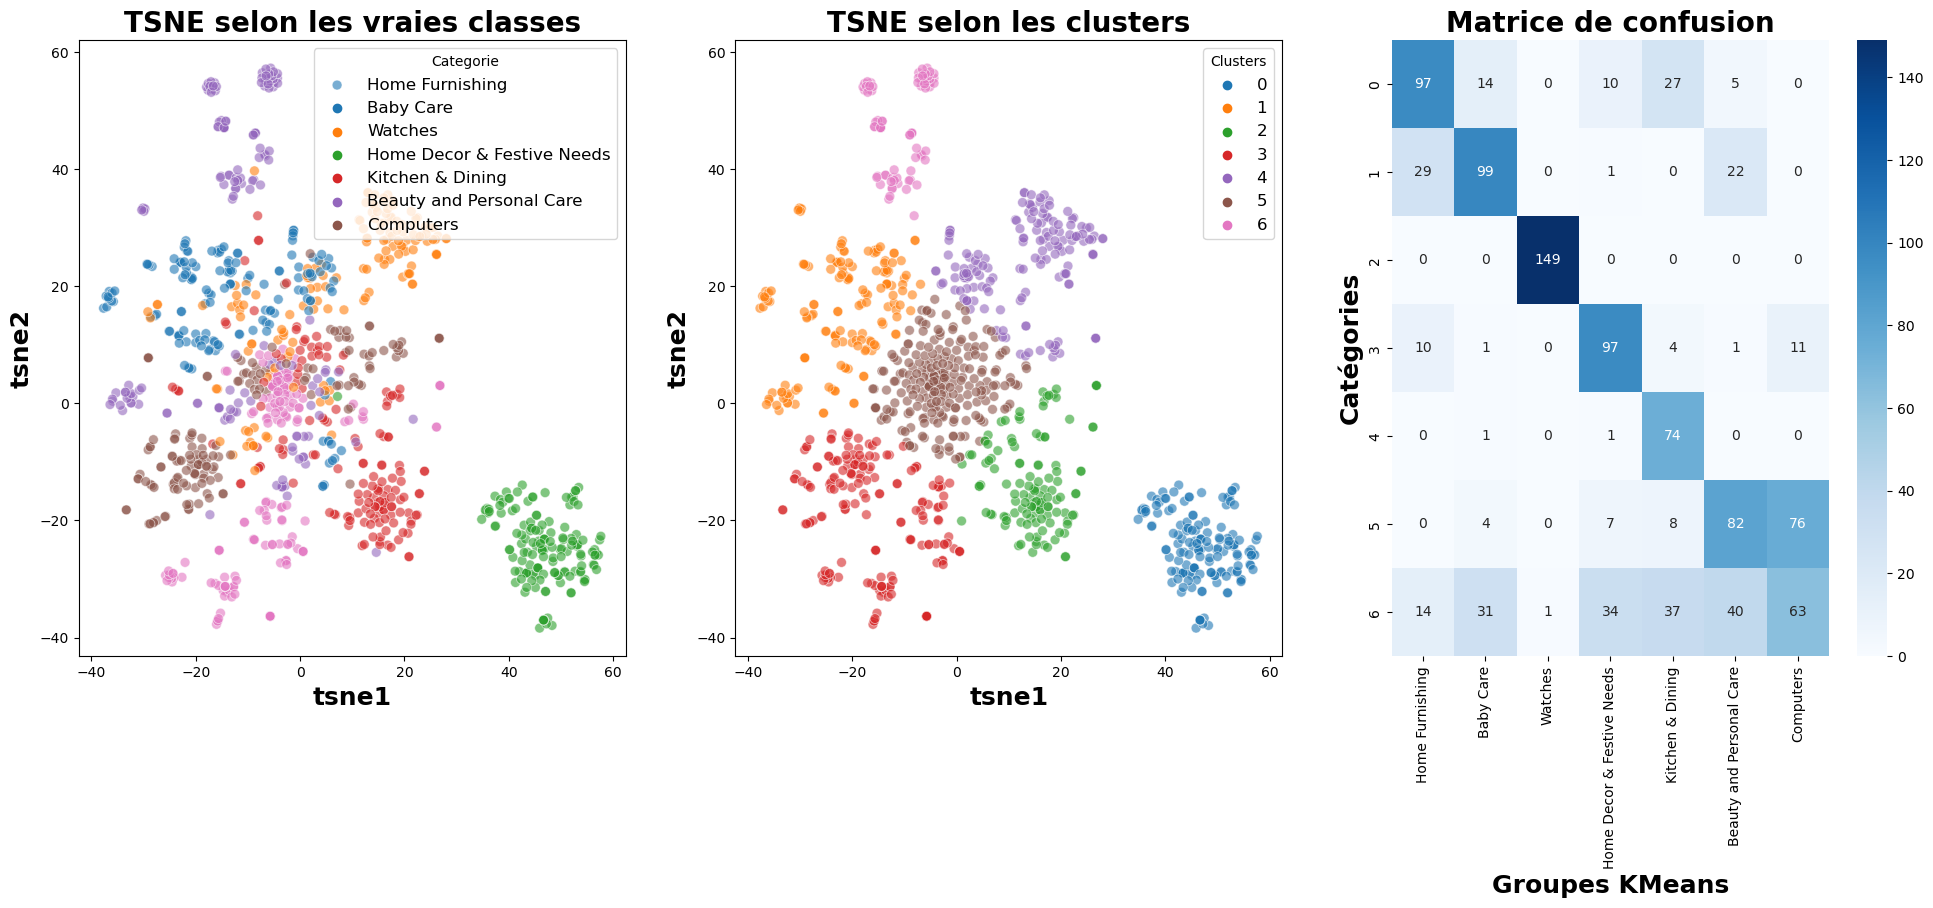

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.403.


In [346]:
# Réduire la dimensionnalité
tsne_data = reduce_dimensionality_tsne(reduced_data)

# Appeler la fonction pour afficher les graphiques et les cluster
plot_tsne_and_kmeans_clusters(tsne_data)

### TF-IDF

**TF-IDF (Term Frequency-Inverse Document Frequency)** est une technique d'évaluation de l'importance d'un mot dans un document par rapport à un corpus de documents. Contrairement au simple comptage des mots (CountVectorizer), TF-IDF prend en compte non seulement la fréquence d'un mot dans un document (TF), mais aussi la fréquence inverse du mot dans l'ensemble du corpus (IDF), ce qui permet de réduire l'importance des mots courants et de mettre en avant les mots plus significatifs pour chaque document.

### Extraction des features

In [347]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le vecteur TF-IDF et l'ajuster sur le texte tokenisé
tfidf_vectorizer = TfidfVectorizer().fit(df['DescriptionCompleteTokenizer'])

# Transformer le texte en une matrice sparse TF-IDF
tfidf_sparse_matrix = tfidf_vectorizer.transform(df['DescriptionCompleteTokenizer'])

tfidf_sparse_matrix

<1050x4109 sparse matrix of type '<class 'numpy.float64'>'
	with 32606 stored elements in Compressed Sparse Row format>

### Réduction dimensionnelle et analyse graphique des clusters

**Le TruncatedSVD** (Singular Value Decomposition tronquée) est une technique de réduction de dimensionnalité utilisée principalement pour les matrices creuses (sparse matrices). Il est particulièrement utile dans le traitement du langage naturel et l'analyse de texte lorsque les données sont représentées sous forme de grandes matrices creuses, comme celles générées par des techniques de bag-of-words ou de TF-IDF.

In [348]:
# Réduction dimensionnelle (PCA n'étant pas adapté aux matrices sparse)
svd_model = TruncatedSVD(n_components=1000, random_state=42)
reduced_data = svd_model.fit_transform(tfidf_sparse_matrix)

reduced_data

array([[ 3.40684761e-02,  1.68886581e-01, -1.07844918e-01, ...,
        -5.96311195e-19,  2.71050543e-18,  5.09575021e-18],
       [ 5.88041164e-02,  1.30449568e-01, -1.67242254e-01, ...,
         5.52943108e-18, -2.81892565e-18,  1.51788304e-18],
       [ 5.36954704e-02,  1.43188100e-01, -1.58699033e-01, ...,
        -8.02309608e-18, -4.77048956e-18, -3.25260652e-18],
       ...,
       [ 5.22384639e-02,  2.87882672e-02, -4.40209915e-02, ...,
        -1.04083409e-17, -5.20417043e-18,  4.33680869e-18],
       [ 7.75798797e-02,  4.95486155e-02, -7.27309126e-02, ...,
        -3.82181266e-18,  1.73472348e-18, -8.67361738e-18],
       [ 8.46578731e-02,  4.62472347e-02, -7.11171594e-02, ...,
        -6.93889390e-18,  1.21430643e-17,  8.67361738e-19]])

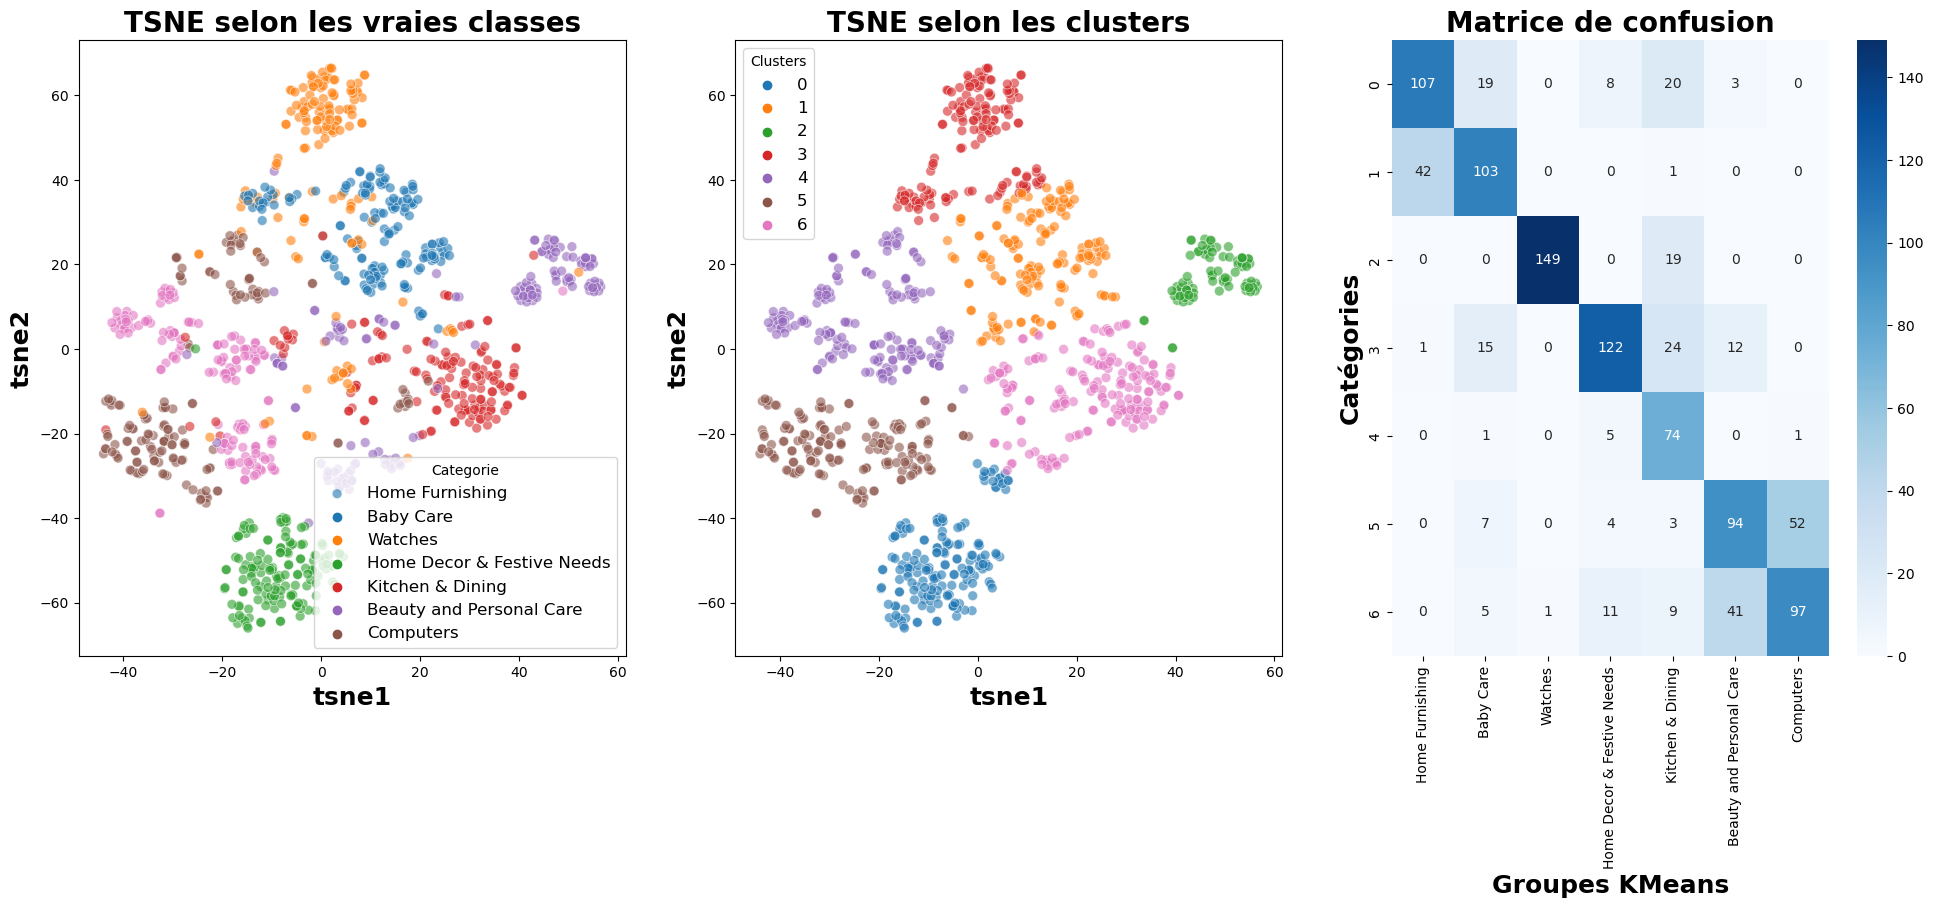

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.494.


In [349]:
# Réduire la dimensionnalité
tsne_data = reduce_dimensionality_tsne(reduced_data)

# Appeler la fonction pour afficher les graphiques et les cluster
plot_tsne_and_kmeans_clusters(tsne_data)

## Approche Word2Vec 

L'approche **Word2Vec** est une méthode avancée pour représenter des mots sous forme de vecteurs continus dans un espace vectoriel de dimension réduite. Contrairement à l'approche Bag-of-words qui compte simplement les occurrences de mots, Word2Vec capture les relations sémantiques entre les mots en les représentant sous forme de vecteurs de taille fixe, où des mots similaires ont des vecteurs similaires.

### Embedding classique

### Extraction des features

In [350]:
# Obtenir le nombre de cœurs du processeur
num_cores = multiprocessing.cpu_count()

# Afficher le nombre de cœurs
print("Nombre de cœurs de l'ordinateur : ", num_cores)

Nombre de cœurs de l'ordinateur :  4


In [351]:
# Prétraiter la colonne 'DescriptionComplete' pour obtenir une liste de mots tokenisés
df['Word2Vec_tokenized_description'] = df['DescriptionComplete'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Paramètres du modèle Word2Vec :
# vector_size : Nombre de dimensions des vecteurs d'embeddings (par défaut 100).
# window : Distance maximale entre le mot cible et les mots contextuels (par défaut 5).
# min_count : Nombre minimal d'occurrences pour qu'un mot soit pris en compte (par défaut 5).
# workers : Nombre de threads utilisés pour l'entraînement (par défaut 3).
# sg : Algorithme d'entraînement utilisé, 0 pour CBOW et 1 pour Skip-gram (par défaut 0).

# Entraîner le modèle Word2Vec
word2vec_model = Word2Vec(sentences=df['Word2Vec_tokenized_description'], vector_size=100, window=5, min_count=2)

# Obtenir le vocabulaire du modèle
vocabulary = set(word2vec_model.wv.index_to_key)

# Transformer les descriptions tokenisées en vecteurs Word2Vec
word_vectors = []
for words in df['Word2Vec_tokenized_description']:
    vector_list = [word2vec_model.wv[word] for word in words if word in vocabulary]
    word_vectors.append(vector_list)

# Calculer la moyenne des vecteurs de mots pour chaque description
averaged_word2vec_vectors = []
for vector_list in word_vectors:
    if vector_list:
        averaged_word2vec_vectors.append(np.mean(vector_list, axis=0))
    else:
        averaged_word2vec_vectors.append(np.zeros(100, dtype=float))

# Convertir les vecteurs moyennés en DataFrame
averaged_word2vec_vectors_df = pd.DataFrame(averaged_word2vec_vectors)

# Afficher le DataFrame résultant
averaged_word2vec_vectors_df

0         1         2         3         4         5         6   \
0    -0.265891  0.402077 -0.067315 -0.332752  0.156103 -0.446900  0.020426   
1    -0.293478  0.416335 -0.163364 -0.602969  0.341191 -0.468304 -0.039970   
2    -0.255025  0.406167 -0.072206 -0.296957  0.159078 -0.467198  0.006007   
3    -0.249193  0.306475 -0.032971 -0.541065  0.332598 -0.374456  0.024480   
4    -0.262087  0.358497 -0.024112 -0.414769  0.249450 -0.424341  0.035970   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.217981  0.378170  0.011052 -0.053897  0.001138 -0.465072  0.041987   
1046 -0.260092  0.455200  0.021029 -0.095414  0.011846 -0.555705  0.050157   
1047 -0.128700  0.302921  0.204128  0.409861 -0.348662 -0.603215 -0.170011   
1048 -0.169292  0.393633  0.268884  0.527516 -0.453006 -0.790308 -0.226116   
1049 -0.166696  0.397320  0.290148  0.583390 -0.493409 -0.811052 -0.235606   

            7         8         9         10        11        12        13  \
0     0.899297 -0.346982  0.009050 -0.532626 -0.473899  0.057398 -0.206754   
1     0.984630 -0.587097  0.243998 -0.723926 -0.554757  0.123410 -0.090474   
2     0.905933 -0.343194  0.002094 -0.549708 -0.475193  0.084884 -0.135572   
3     0.790246 -0.560319  0.224095 -0.583251 -0.595633  0.097213 -0.109497   
4     0.865610 -0.451028  0.099972 -0.573920 -0.561724  0.075275 -0.163623   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.817521 -0.134431 -0.185278 -0.390164 -0.406131  0.050142 -0.180941   
1046  0.981086 -0.169623 -0.209858 -0.482207 -0.487524  0.066961 -0.241335   
1047  0.932057 -0.375420 -0.377065 -0.390712 -0.720124  0.354717  0.391007   
1048  1.221112 -0.495380 -0.489016 -0.513266 -0.943703  0.463276  0.504438   
1049  1.245379 -0.499877 -0.525197 -0.510390 -0.977041  0.486478  0.542306   

            14        15        16        17        18        19        20  \
0     0.111389 -0.443907 -0.045343 -0.667142  0.101302 -0.559058  0.398956   
1     0.349544 -0.682382 -0.039530 -0.783205  0.108856 -0.548023  0.548684   
2     0.150704 -0.400379 -0.029744 -0.652765  0.098340 -0.540485  0.395787   
3     0.318354 -0.673878  0.006908 -0.779997  0.111014 -0.488887  0.526368   
4     0.220009 -0.566258 -0.009252 -0.763340  0.113827 -0.538545  0.476765   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.024279 -0.143497 -0.028182 -0.523433  0.078757 -0.508270  0.242936   
1046 -0.022069 -0.201415 -0.035890 -0.653094  0.105315 -0.628596  0.301642   
1047  0.211112  0.120735  0.363694 -0.617228  0.056426 -0.940189  0.403614   
1048  0.283005  0.144345  0.476642 -0.819194  0.077623 -1.236230  0.536014   
1049  0.283389  0.187817  0.505150 -0.825297  0.076960 -1.278504  0.542611   

            21        22        23        24        25        26        27  \
0    -0.153620  0.178236 -0.209370 -0.083260 -0.179053 -0.019789 -0.143145   
1    -0.345811  0.295528 -0.433360  0.209181 -0.455559 -0.105758 -0.354461   
2    -0.144537  0.176037 -0.207671 -0.032420 -0.149959 -0.076178 -0.158417   
3    -0.287370  0.116563 -0.388570  0.144641 -0.470717  0.061860 -0.381131   
4    -0.204837  0.118083 -0.289919  0.019941 -0.318732  0.037081 -0.274533   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.044812  0.061279 -0.028101 -0.236971  0.109262 -0.059137  0.039303   
1046  0.036955  0.081375 -0.040062 -0.295064  0.114518 -0.040295  0.039204   
1047  0.092049 -0.212380 -0.016379 -0.208205  0.445043 -0.357785 -0.142399   
1048  0.115086 -0.271104 -0.026898 -0.266063  0.571885 -0.459119 -0.198771   
1049  0.137566 -0.303376 -0.009205 -0.291374  0.624203 -0.484305 -0.190002   

            28        29        30        31        32        33        34  \
0    -0.601201 -0.065518  0.136824  0.285162 -0.202491 -0.256725  0.045615   
1    -0.960272 -0.176943 -0.069399  0.702325 -0.262152 -0.495870  0.255547   
2    -0.605974 -0.060698  0.10

### Réduction dimensionnelle et analyse graphique des clusters

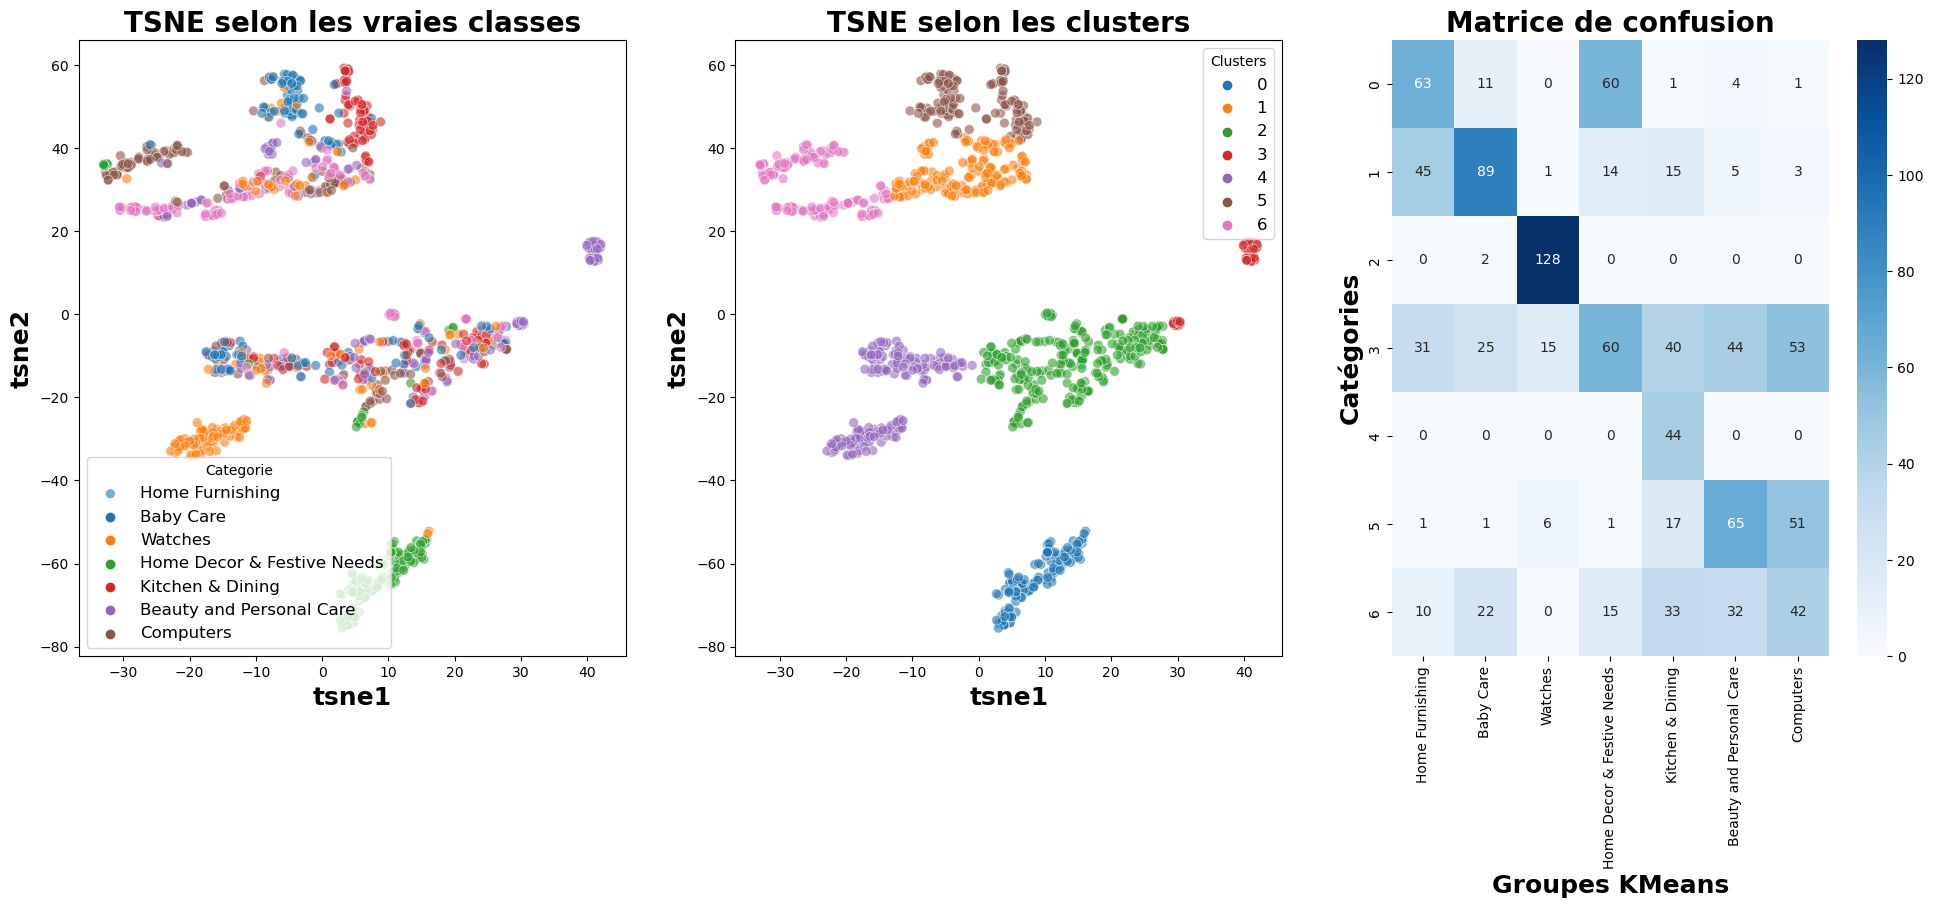

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.23.


In [352]:
# Réduire la dimensionnalité
tsne_data = reduce_dimensionality_tsne(averaged_word2vec_vectors_df)

# Appeler la fonction pour afficher les graphiques et les cluster
plot_tsne_and_kmeans_clusters(tsne_data)

## Approche BERT

L'approche **BERT (Bidirectional Encoder Representations from Transformers)** est une méthode avancée pour obtenir des représentations contextuelles de mots et de phrases. Contrairement aux modèles traditionnels comme Word2Vec, BERT prend en compte le contexte des mots dans les deux directions (avant et arrière) pour capturer des significations plus riches et plus précises.

### Extraction des features

In [355]:
# Division de la DataFrame en deux parties en utilisant StratifiedKFold
# Cette étape est nécessaire car BERT est trop lourd pour être exécuté sur les CPU disponibles

# Initialiser StratifiedKFold pour diviser les données en 2 parties tout en conservant la proportion des classes
stratified_kfold = StratifiedKFold(n_splits=2)

# Variables pour stocker les deux parties de la DataFrame
part1_df = None
part2_df = None

# Diviser les données en utilisant StratifiedKFold
for part1_index, part2_index in stratified_kfold.split(df['DescriptionComplete'], df['Category_Level_1']):
    part1_df = df.loc[part1_index, :]
    part2_df = df.loc[part2_index, :]

# Afficher la distribution des classes dans chaque partie
part1_class_distribution = part1_df['Category_Level_1'].value_counts()
part2_class_distribution = part2_df['Category_Level_1'].value_counts()

# Afficher les distributions
print("Distribution des classes dans la première partie:")
print(part1_class_distribution)
print("\nDistribution des classes dans la deuxième partie:")
print(part2_class_distribution)

Distribution des classes dans la première partie:
0    75
1    75
2    75
3    75
4    75
5    75
6    75
Name: Category_Level_1, dtype: int64

Distribution des classes dans la deuxième partie:
4    75
3    75
5    75
6    75
2    75
1    75
0    75
Name: Category_Level_1, dtype: int64


**Nombre égal dans chaque catégorie.**
Les classes sont bien réparties de manière égale dans les deux parties du dataframe.

In [358]:
import time
from transformers import AutoTokenizer, TFAutoModel

def extraire_caracteristiques_textuelles_avec_bert(df):
    """
    Extraire les caractéristiques textuelles en utilisant le modèle BERT.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant une colonne 'DescriptionComplete' avec des données textuelles.

    Retourne:
    np.ndarray: Caractéristiques extraites du modèle BERT.
    """
    
    # Extraction des phrases du DataFrame
    phrases = df['DescriptionComplete'].values.tolist()
    taille_lot = 10  # Taille du batch
    longueur_max = 64  # Longueur maximale des séquences
    nom_modele = 'bert-base-uncased'  # Type de modèle BERT
    
    # Chargement du tokenizer et du modèle BERT
    tokenizer = AutoTokenizer.from_pretrained(nom_modele)
    modele = TFAutoModel.from_pretrained(nom_modele)
    
    # Enregistrement du temps de début
    debut_temps = time.time()

    # Traitement des phrases par lots
    for etape in range(len(phrases) // taille_lot):
        idx_debut_lot = etape * taille_lot
        
        ids_entree = []
        ids_type_token = []
        masques_attention = []

        # Tokenisation des phrases dans le lot
        for phrase in phrases[idx_debut_lot:idx_debut_lot + taille_lot]:
            entree_encodee = tokenizer.encode_plus(
                phrase,
                add_special_tokens=True,
                max_length=longueur_max,
                padding='max_length',
                return_attention_mask=True, 
                return_token_type_ids=True,
                truncation=True,
                return_tensors='tf'
            )

            ids_entree.append(entree_encodee['input_ids'][0])
            ids_type_token.append(entree_encodee['token_type_ids'][0])
            masques_attention.append(entree_encodee['attention_mask'][0])

        ids_entree = np.asarray(ids_entree)
        ids_type_token = np.asarray(ids_type_token)
        masques_attention = np.asarray(masques_attention)
        
        # Création d'un dictionnaire avec les textes prétraités
        texte_pretraite = {
            "input_ids": ids_entree, 
            "attention_mask": masques_attention, 
            "token_type_ids": ids_type_token
        }
        
        # Obtention des sorties du modèle BERT
        sorties_modele = modele(texte_pretraite)
        derniers_etats_caches = sorties_modele[0]
             
        if etape == 0:
            tous_etats_caches = derniers_etats_caches
        else:
            tous_etats_caches = np.concatenate((tous_etats_caches, derniers_etats_caches), axis=0)
    
    # Calcul de la moyenne des derniers états cachés
    caracteristiques_bert = np.mean(tous_etats_caches, axis=1)
    
    # Enregistrement du temps de fin et calcul du temps écoulé
    fin_temps = np.round(time.time() - debut_temps, 0)
    print("Temps de traitement : ", fin_temps, "secondes")
    
    return caracteristiques_bert

In [359]:
features_bert = extraire_caracteristiques_textuelles_avec_bert(df)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Temps de traitement :  142.0 secondes


In [360]:
# Afficher la forme des arrays
print(features_bert.shape)

(1050, 768)


### Réduction dimensionnelle et analyse graphique des clusters

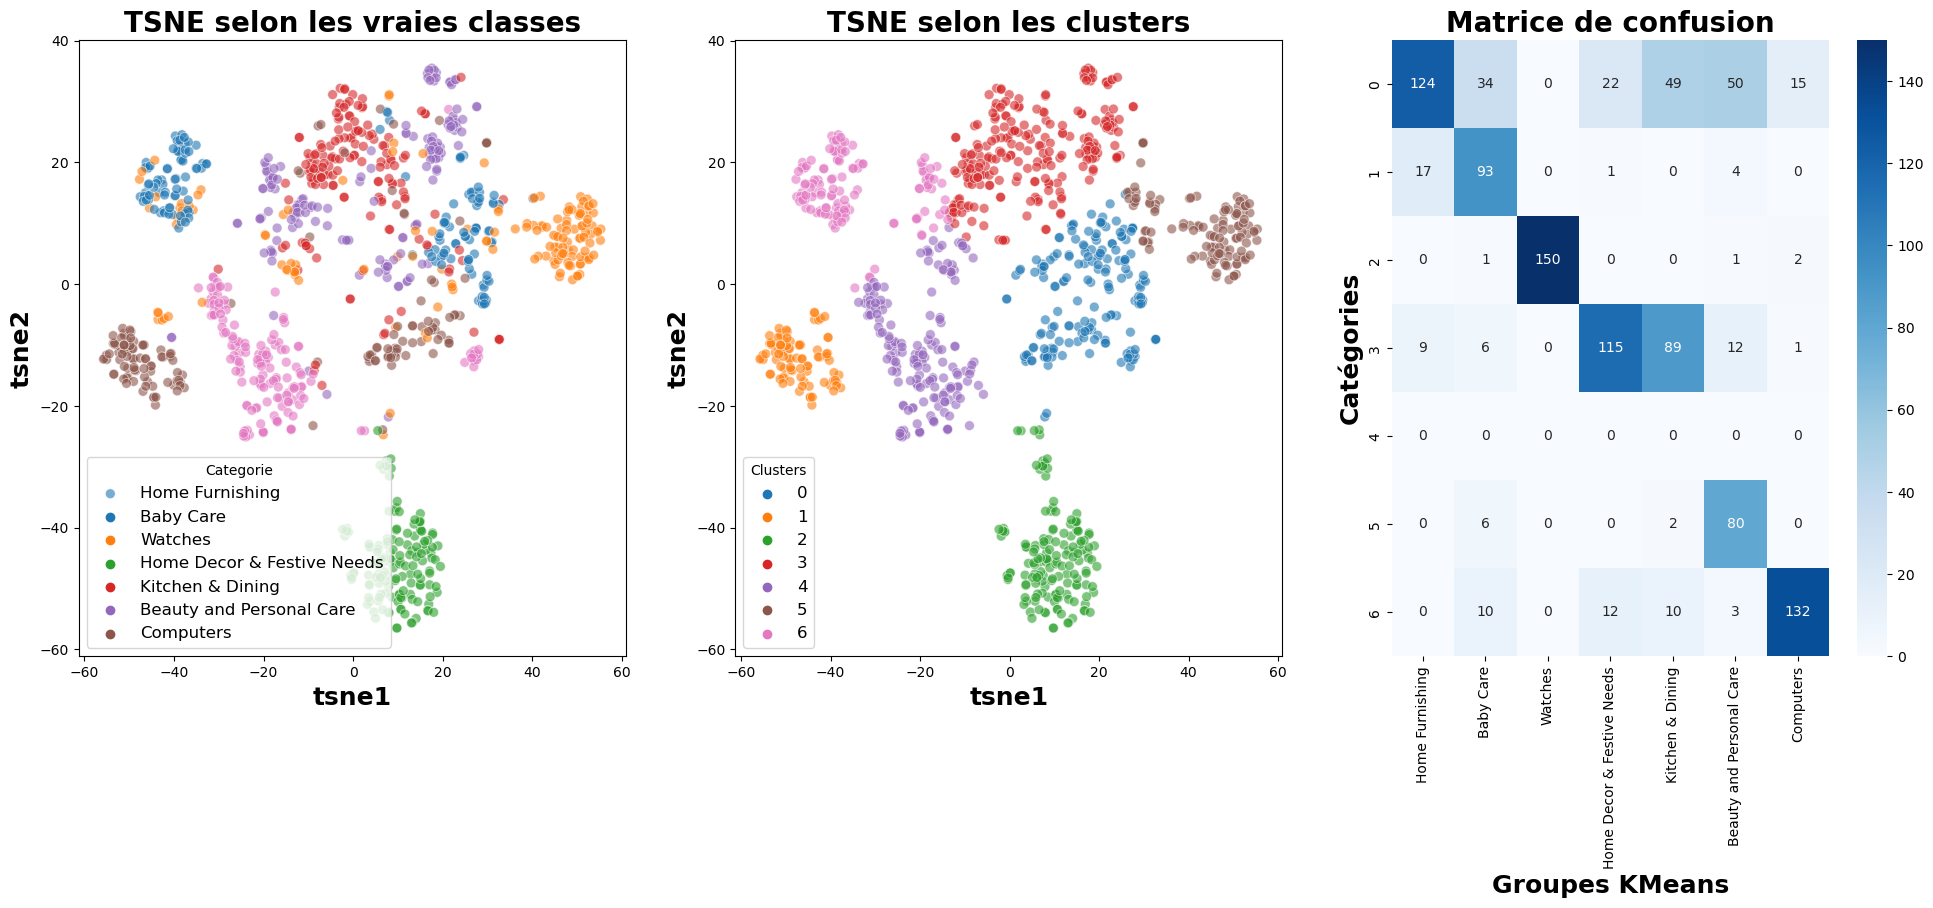

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.466.


In [361]:
# Réduction des dimensions avec PCA
# 'arr' contient les états cachés extraits de BERT
# On commence par aplatir les états cachés en une matrice 2D (525 échantillons, chacun ayant 768 dimensions)
flattened_data = pd.DataFrame(features_bert.reshape(1050, 768))

# Appliquer PCA pour réduire les dimensions tout en conservant 99% de la variance
pca_reduced_data = reduce_dimensionality_pca(flattened_data, 0.99)

# Appliquer t-SNE pour une visualisation en 2D
tsne_transformed_data = reduce_dimensionality_tsne(pca_reduced_data)

# Afficher les graphiques des clusters et calculer le score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_data)

## Approche USE

L'approche **USE (Universal Sentence Encoder)** est une méthode avancée pour obtenir des représentations vectorielles de phrases et de textes. Développé par Google, USE produit des embeddings de haute qualité pour des phrases entières plutôt que des mots individuels. Il est particulièrement utile pour des tâches telles que la classification de texte, la similarité de texte et le clustering de texte.

### Extraction des features

In [362]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import tarfile

# Chemin vers l'archive téléchargée
local_model_path = r"C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 6\archive.tar.gz"
extracted_model_path = r"C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 6\extracted_model"

# Extraire l'archive tar.gz
if not os.path.exists(extracted_model_path):
    os.makedirs(extracted_model_path)
    with tarfile.open(local_model_path, 'r:gz') as tar:
        tar.extractall(path=extracted_model_path)

# Charger le modèle Universal Sentence Encoder depuis le chemin local extrait
embed = hub.load(extracted_model_path)

# Appliquer l'encodage USE à la colonne 'DescriptionCompleteTokenizer'
sentences = df['DescriptionCompleteTokenizer'].tolist()
embeddings = embed(sentences)

# Convertir les embeddings en DataFrame pour une analyse ultérieure
embeddings_df = pd.DataFrame(embeddings.numpy())

# Afficher le DataFrame résultant
embeddings_df

0         1         2         3         4         5         6    \
0    -0.056900 -0.055884  0.024777  0.051274 -0.025428  0.005560 -0.003274   
1    -0.045888 -0.030619  0.009958  0.030758  0.046606  0.059890  0.050018   
2    -0.054185 -0.047169 -0.041173  0.054108  0.051960  0.055114  0.052701   
3    -0.056918 -0.056241  0.053026  0.041883  0.056531  0.037843  0.018228   
4    -0.053433 -0.050493  0.052383  0.048631  0.053453  0.036025  0.031248   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.049043 -0.035552 -0.040362  0.051281 -0.042762  0.049319 -0.045609   
1046 -0.059630  0.018660  0.039962  0.056629  0.023670  0.042034 -0.035333   
1047  0.013828 -0.056825  0.056367  0.029820 -0.005534  0.052780 -0.060470   
1048 -0.008882 -0.037847  0.062931  0.051630  0.050581  0.036817 -0.065340   
1049 -0.037916 -0.066671  0.055501  0.054297  0.036137  0.050263 -0.052891   

           7         8         9         10        11        12        13   \
0     0.054892 -0.050546  0.004385 -0.043074 -0.001388  0.023480 -0.057661   
1    -0.023201 -0.005561 -0.044719 -0.030233  0.052642 -0.050099 -0.055921   
2     0.020008 -0.030002  0.032647 -0.044638  0.052755 -0.032505 -0.055187   
3     0.014960  0.025531 -0.045638 -0.004072  0.056879 -0.012081 -0.052755   
4     0.050435 -0.000892 -0.037911 -0.046332  0.053574 -0.040488 -0.053554   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.038795 -0.051426  0.051384 -0.041701 -0.041388 -0.040008 -0.051426   
1046  0.058782  0.008973  0.021449 -0.059930  0.037661 -0.019113 -0.051230   
1047  0.011990  0.011440 -0.054345 -0.056765 -0.008684  0.010118  0.044936   
1048  0.023252 -0.001716 -0.065392 -0.050297 -0.059967 -0.064756  0.041260   
1049 -0.011250  0.037938 -0.073021 -0.039928 -0.056267 -0.057095  0.046443   

           14        15        16        17        18        19        20   \
0     0.054374  0.056174  0.056495  0.017897  0.056999  0.040431 -0.049120   
1     0.059444 -0.056828  0.056013 -0.050963  0.041082  0.046326 -0.004008   
2     0.055089 -0.025742  0.054274 -0.050837  0.015926  0.038525 -0.002178   
3     0.056173  0.056094  0.055835  0.033437 -0.045234  0.052726 -0.029380   
4     0.053476  0.053561  0.053162  0.011793 -0.036331  0.046087 -0.043205   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.051015  0.051425  0.050944  0.051425  0.051276 -0.049316 -0.006066   
1046  0.013472  0.055343  0.033409 -0.012695 -0.050918 -0.035238 -0.047345   
1047 -0.016201  0.013674  0.028690 -0.028916  0.057992  0.018855 -0.043082   
1048 -0.004352  0.005361  0.035790 -0.063651  0.060981 -0.012828 -0.051176   
1049  0.008076 -0.010101 -0.002106 -0.062841  0.053863  0.044614 -0.037683   

           21        22        23        24        25        26        27   \
0    -0.019847  0.006239 -0.056280 -0.018068 -0.051278  0.041237  0.020035   
1     0.032450  0.049534 -0.059792  0.022907  0.035765 -0.000960  0.038409   
2     0.050446  0.053018 -0.055161  0.053701  0.021065 -0.045104  0.021712   
3     0.033717  0.054960 -0.056834  0.037642  0.052391 -0.012933 -0.042398   
4     0.043760  0.051683 -0.053557  0.052746  0.034458  0.022930 -0.004582   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.021865 -0.032203 -0.050600  0.043932  0.051409 -0.044207 -0.051120   
1046 -0.034709  0.027549 -0.060311 -0.029189  0.058991 -0.054377 -0.043081   
1047 -0.070655  0.016226 -0.041684  0.060239 -0.002709 -0.011121 -0.045999   
1048 -0.036495  0.012886 -0.046792 -0.052175 -0.019372  0.009476  0.005048   
1049 -0.035219  0.004370 -0.011425 -0.070018 -0.000024  0.036782 -0.009123   

           28        29        30        31        32        33        34   \
0     0.053233  0.039108  0.057872  0.013233  0.047124 -0.053186  0.035751   
1     0.043580 -0.048122  0.059892 -0.043086  0.043974 -0.034831 -0.037498   
2     0.039894 -0.054412  0.0

### Réduction dimensionnelle et analyse graphique des clusters

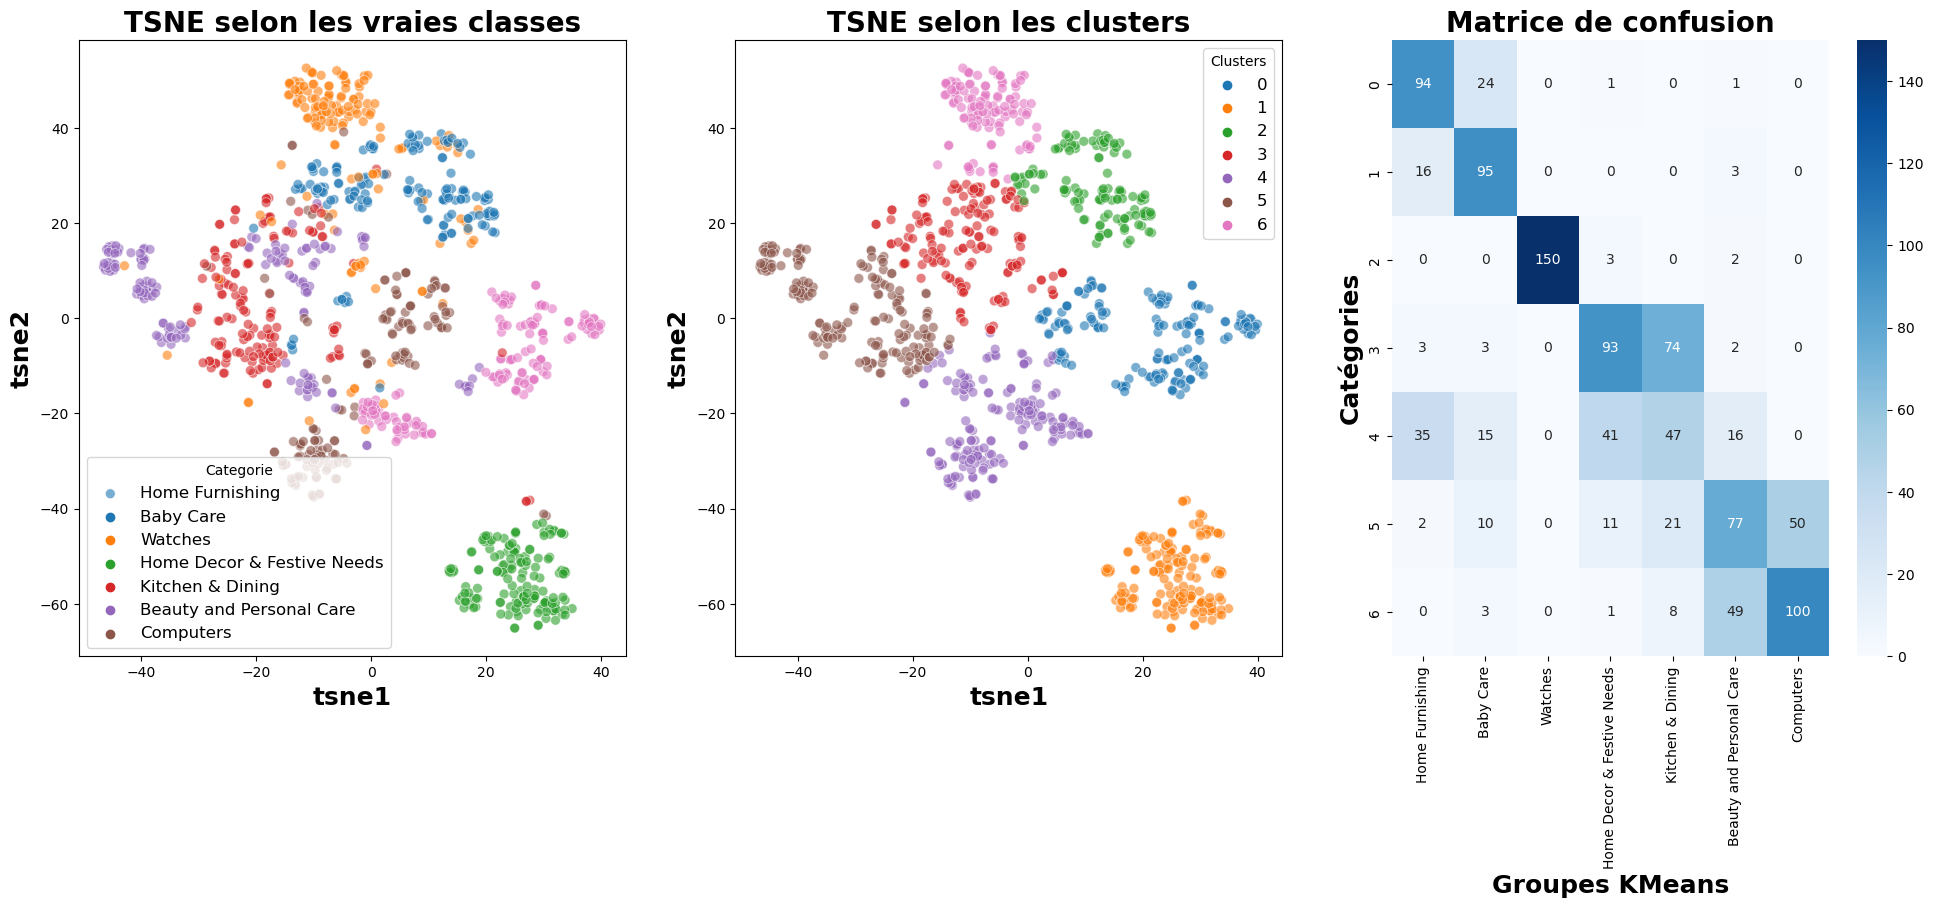

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.434.


In [363]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Réduction des dimensions avec PCA
# Appliquer PCA pour réduire les dimensions tout en conservant 99% de la variance
pca_reduced_embeddings = reduce_dimensionality_pca(embeddings_df, 0.99)

# Appliquer t-SNE pour une visualisation en 2D
tsne_transformed_embeddings = reduce_dimensionality_tsne(pca_reduced_embeddings)

# Afficher les graphiques des clusters et calculer le score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_embeddings)

In [364]:
# Exporter les embeddings du modèle USE
use_embeddings_filepath = 'VariablesUSE.csv'

# Sauvegarder les embeddings 
embeddings_df.to_csv(use_embeddings_filepath, index=False)

### Observation BERT et USE

   - **BERT** : Avec un ARI de 0.466, le modèle BERT semble mieux capturer les nuances des descriptions textuelles des articles pour les catégoriser correctement par rapport à USE.
   - **USE** : Un ARI de 0.434 est toujours un résultat prometteur, bien que légèrement inférieur à BERT, ce qui suggère que USE est également efficace pour cette tâche mais avec une précision légèrement moindre.

# Transformation des images

In [365]:
from PIL import Image

# Fonction pour obtenir le nombre total de pixels dans une image donnée
def obtenir_nombre_pixels(chemin_fichier):
    largeur, hauteur = Image.open(chemin_fichier).size
    return largeur * hauteur

# Liste pour stocker les indices des images dont la taille dépasse la limite
indices_images_trop_grandes = []

# Parcourir toutes les images dans le DataFrame
for i in range(len(df)):
    limite_pixels = 89478485 # Limite de pixels pour éviter DecompressionBombWarning
    nombre_pixels = obtenir_nombre_pixels("Flipkart/Images/" + df['image'][i])
    if nombre_pixels > limite_pixels:
        indices_images_trop_grandes.append(i)

print('Les images dépassant la taille limite se trouvent aux indices :', indices_images_trop_grandes)

# Réduire la taille des images trop grandes et mettre à jour le DataFrame
for index in indices_images_trop_grandes:
    nom_image = df['image'].iloc[index]
    image_lue = Image.open("Flipkart/Images/" + nom_image)
    dimensions = image_lue.size
    print("Dimensions originales :", dimensions)

    # Générer un nouveau nom pour l'image compressée
    nom_image_compressee = nom_image.split('.')[0] + '2' + '.png'

    # Redimensionner l'image
    image_compressee = image_lue.resize((int(dimensions[0] / 1.1), int(dimensions[1] / 1.1)))
    image_compressee.save("Flipkart/Images/" + nom_image_compressee)
    
    dimensions_compressees = image_compressee.size
    print("Dimensions compressées :", dimensions_compressees)
    
    # Mettre à jour le DataFrame avec le nouveau nom de fichier de l'image compressée
    df['image'].iloc[index] = df['image'].iloc[index].replace(nom_image, nom_image_compressee)
    df['image'].iloc[index]

Les images dépassant la taille limite se trouvent aux indices : [677]
Dimensions originales : (8484, 11042)
Dimensions compressées : (7712, 10038)


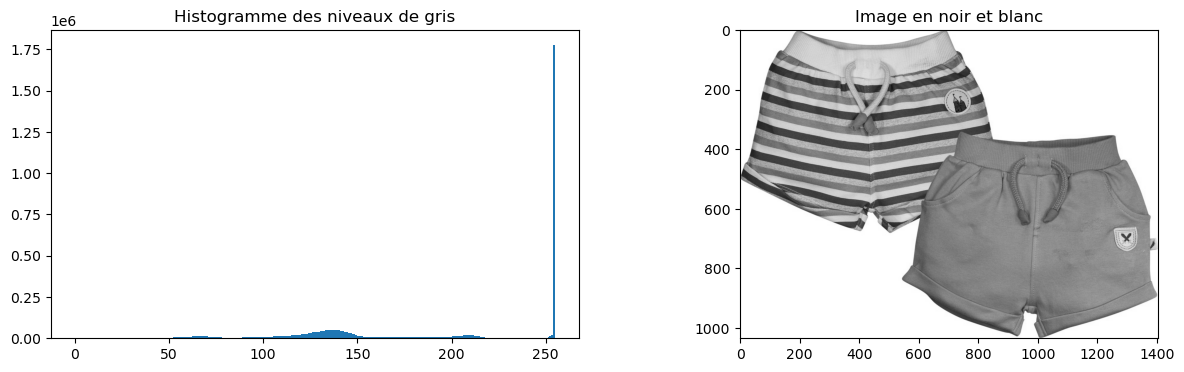

In [366]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

# Chargement d'une image depuis le chemin spécifié
chemin_image = "Flipkart/Images/dc0b5ef48b4c132d0651613a9c1e8e40.jpg"
image = Image.open(chemin_image)

# Conversion de l'image en noir et blanc
filtre_noir_blanc = ImageEnhance.Color(image)
image_noir_blanc = filtre_noir_blanc.enhance(0)
image_array = np.array(image_noir_blanc)

# Affichage des niveaux de gris
plt.figure(figsize=(15, 4))

# Histogramme des niveaux de gris
plt.subplot(121)
niveaux, bins, patches = plt.hist(image_array.flatten(), bins=range(256))
plt.title("Histogramme des niveaux de gris")

# Affichage de l'image en noir et blanc
plt.subplot(122)
plt.imshow(image_noir_blanc, cmap='gray')
plt.title("Image en noir et blanc")
plt.show()

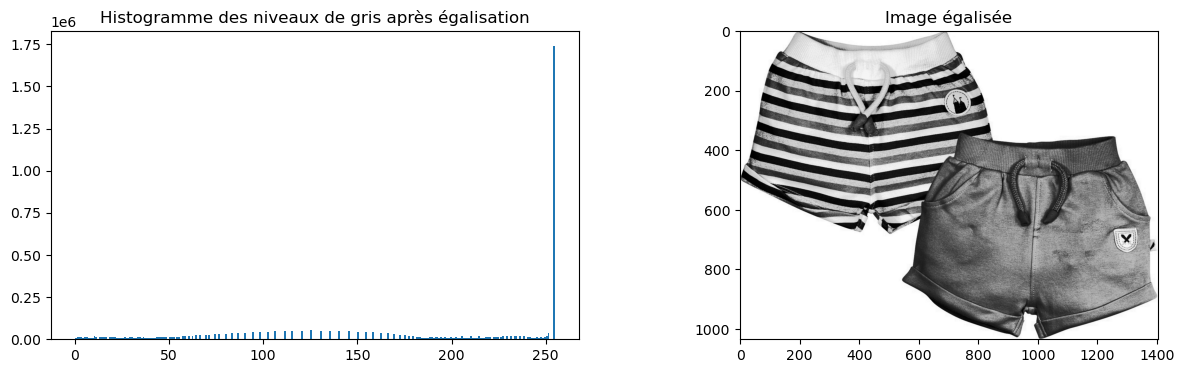

In [367]:
from PIL import ImageOps

# Égalisation de l'image
image_equalisee = ImageOps.equalize(image_noir_blanc, mask=None)
image_array_equalisee = np.array(image_equalisee)

# Affichage des niveaux de gris après égalisation
plt.figure(figsize=(15, 4))

# Histogramme des niveaux de gris de l'image égalisée
plt.subplot(121)
niveaux_equalises, bins_equalises, patches_equalises = plt.hist(image_array_equalisee.flatten(), bins=range(256))
plt.title("Histogramme des niveaux de gris après égalisation")

# Affichage de l'image égalisée
plt.subplot(122)
plt.imshow(image_equalisee, cmap='gray')
plt.title("Image égalisée")
plt.show()

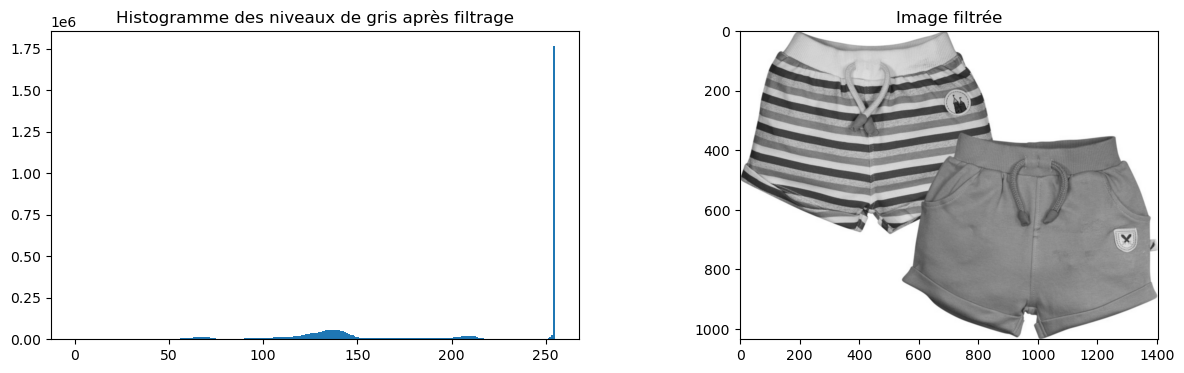

In [368]:
from PIL import ImageFilter

# Filtrage du bruit en utilisant le filtre BoxBlur
image_filtree = image_noir_blanc.filter(ImageFilter.BoxBlur(1))
image_array_filtree = np.array(image_filtree)

# Affichage des niveaux de gris après filtrage
plt.figure(figsize=(15, 4))

# Histogramme des niveaux de gris de l'image filtrée
plt.subplot(121)
niveaux_filtrees, bins_filtrees, patches_filtrees = plt.hist(image_array_filtree.flatten(), bins=range(256))
plt.title("Histogramme des niveaux de gris après filtrage")

# Affichage de l'image filtrée
plt.subplot(122)
plt.imshow(image_filtree, cmap='gray')
plt.title("Image filtrée")
plt.show()

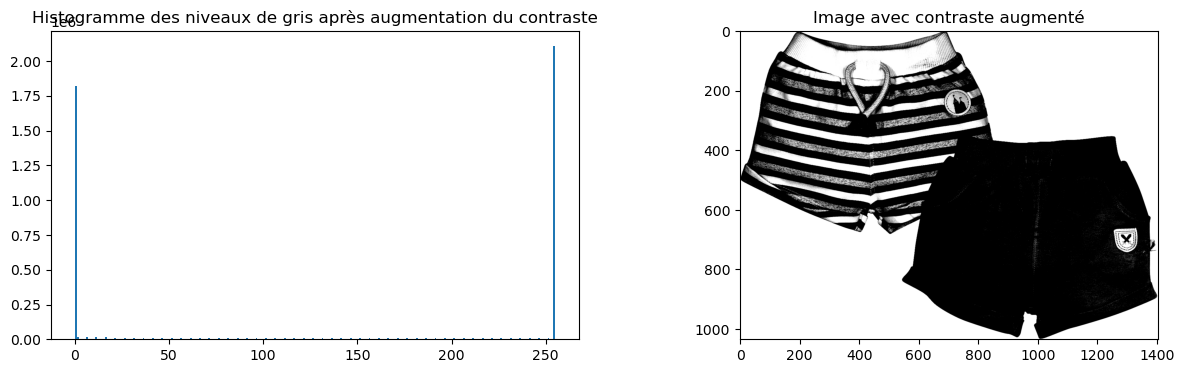

In [369]:
from PIL import ImageEnhance

# Amélioration du contraste de l'image
amplificateur_contraste = ImageEnhance.Contrast(image_noir_blanc)
image_augmentee_contraste = amplificateur_contraste.enhance(5)
image_array_augmentee_contraste = np.array(image_augmentee_contraste)

# Affichage des niveaux de gris après augmentation du contraste
plt.figure(figsize=(15, 4))

# Histogramme des niveaux de gris de l'image avec contraste augmenté
plt.subplot(121)
niveaux_augmentes_contraste, bins_augmentes_contraste, patches_augmentes_contraste = plt.hist(image_array_augmentee_contraste.flatten(), bins=range(256))
plt.title("Histogramme des niveaux de gris après augmentation du contraste")

# Affichage de l'image avec contraste augmenté
plt.subplot(122)
plt.imshow(image_augmentee_contraste, cmap='gray')
plt.title("Image avec contraste augmenté")
plt.show()

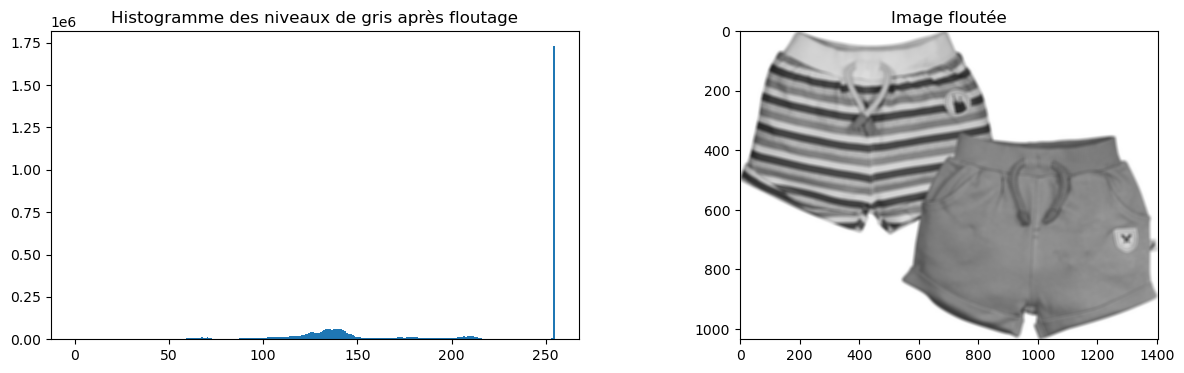

In [370]:
from PIL import ImageFilter

# Application d'un flou à l'image
image_floutee = image_noir_blanc.filter(ImageFilter.BoxBlur(6))
image_array_floutee = np.array(image_floutee)

# Affichage des niveaux de gris après floutage
plt.figure(figsize=(15, 4))

# Histogramme des niveaux de gris de l'image floutée
plt.subplot(121)
niveaux_floutes, bins_floutes, patches_floutes = plt.hist(image_array_floutee.flatten(), bins=range(256))
plt.title("Histogramme des niveaux de gris après floutage")

# Affichage de l'image floutée
plt.subplot(122)
plt.imshow(image_floutee, cmap='gray')
plt.title("Image floutée")
plt.show()

## SIFT

**SIFT (Scale-Invariant Feature Transform)** est un algorithme développé par David Lowe en 1999. Il est conçu pour détecter et décrire des points d'intérêt dans des images de manière robuste aux transformations d'échelle et de rotation. Voici les étapes principales de l'algorithme SIFT :

1. **Détection des Points-Clés :**
   - Identifier les points d'intérêt dans une image qui sont invariants à l'échelle et à la rotation.
   - Utilisation d'une série d'opérations de filtrage sur l'image à différentes échelles pour détecter les points d'intérêt (blobs).

2. **Description des Points-Clés :**
   - Pour chaque point d'intérêt, une région autour du point est extraite.
   - Cette région est normalisée (en termes d'échelle et d'orientation) pour garantir l'invariance aux transformations.
   - Un vecteur de caractéristiques (ou descripteur) est calculé pour cette région, capturant l'information locale sur la texture et l'orientation des gradients.

3. **Correspondance des Points-Clés :**
   - Les descripteurs des points-clés d'une image peuvent être comparés à ceux d'autres images.
   - Cette correspondance permet de trouver des similarités entre les images, utile pour des applications comme la reconnaissance d'objets, la mosaïque d'images, etc.

### Extraction des features

#### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("tous_les_descripteurs_sift") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("tous_les_descripteurs_sift") qui sera utilisé pour créer les clusters de descripteurs

In [371]:
import cv2
import tqdm
import time

# Définition du chemin des images
chemin_images = 'Flipkart/Images/'

# Liste pour stocker les descripteurs SIFT des images
descripteurs_sift = []

# Création de l'objet SIFT avec un maximum de 500 points d'intérêt
sift = cv2.SIFT_create(500)

# Mesure du temps de traitement
temps1 = time.time()

# Extraction des descripteurs SIFT pour chaque image
for index in range(len(df['image'])):
    if index % 100 == 0:
        print(f"Traitement de l'image {index}")

    # Lecture de l'image en niveaux de gris
    image_gris = cv2.imread(chemin_images + df['image'][index], 0)
    
    # Égalisation de l'histogramme de l'image
    image_equalisee = cv2.equalizeHist(image_gris)
    
    # Détection et calcul des descripteurs SIFT
    points_interet, descripteurs = sift.detectAndCompute(image_equalisee, None)
    
    # Ajout des descripteurs à la liste s'ils ne sont pas None
    if descripteurs is not None:
        descripteurs_sift.append(descripteurs)

# Vérifiez que la liste descripteurs_sift n'est pas vide
if descripteurs_sift:
    # Concatenation de tous les descripteurs SIFT en un seul tableau
    tous_les_descripteurs_sift = np.concatenate(descripteurs_sift, axis=0)
else:
    tous_les_descripteurs_sift = np.array([])  # Si la liste est vide, créez un tableau numpy vide

print()
print("Nombre total de descripteurs SIFT:", tous_les_descripteurs_sift.shape)

# Calcul de la durée du traitement
duree_traitement = time.time() - temps1
print("Temps de traitement des descripteurs SIFT : {:.2f} secondes".format(duree_traitement))

Traitement de l'image 0
Traitement de l'image 100
Traitement de l'image 200
Traitement de l'image 300
Traitement de l'image 400
Traitement de l'image 500
Traitement de l'image 600
Traitement de l'image 700
Traitement de l'image 800
Traitement de l'image 900
Traitement de l'image 1000

Nombre total de descripteurs SIFT: (517352, 128)
Temps de traitement des descripteurs SIFT : 471.21 secondes


#### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables, le Kmean est plus lourd en temps de traitement

* Il existe plusieurs approches pour déterminer le nombre de clusters. Une méthode consiste à utiliser la racine carrée du nombre total de descripteurs, qui représente les futures caractéristiques. Une autre méthode consiste à prendre le nombre de catégories souhaitées et le multiplier par 10.

**la racine carré total du nombre de descripyeur (nombre de clusters maximal)**
**multiplié par 10 le nombre de catégorie (nombre de cluster minimal**

In [372]:
from sklearn import cluster

# Détermination du nombre de clusters en fonction du nombre total de descripteurs SIFT
temps1 = time.time()

nombre_clusters = int(round(np.sqrt(len(tous_les_descripteurs_sift)), 0))
print("Nombre de clusters estimés : ", nombre_clusters)
print("Création de", nombre_clusters, "clusters de descripteurs ...")

# Clustering des descripteurs SIFT en utilisant MiniBatchKMeans
kmeans = cluster.MiniBatchKMeans(n_clusters=nombre_clusters, init_size=3*nombre_clusters, random_state=0)
kmeans.fit(tous_les_descripteurs_sift)

# Calcul de la durée du traitement
duree_traitement = time.time() - temps1
print("Temps de traitement kmeans : {:.2f} secondes".format(duree_traitement))

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
Temps de traitement kmeans : 7.81 secondes


In [373]:
# Création des histogrammes (caractéristiques)
def construire_histogramme(kmeans, descripteurs, numero_image):
    # Prédiction des clusters pour les descripteurs de l'image
    clusters = kmeans.predict(descripteurs)
    # Initialisation de l'histogramme avec des zéros
    histogramme = np.zeros(len(kmeans.cluster_centers_))
    nombre_descripteurs = len(descripteurs)
    if nombre_descripteurs == 0:
        print("Problème avec l'histogramme de l'image :", numero_image)
    # Comptage des occurrences de chaque cluster dans les descripteurs
    for cluster in clusters:
        histogramme[cluster] += 1.0 / nombre_descripteurs
    return histogramme

# Création d'une matrice d'histogrammes
vecteurs_histogrammes = []

for i, descripteurs_image in enumerate(descripteurs_sift):
    # Calcul de l'histogramme pour l'image
    histogramme = construire_histogramme(kmeans, descripteurs_image, i)
    # Ajout de l'histogramme à la liste des vecteurs de caractéristiques
    vecteurs_histogrammes.append(histogramme)

# Conversion de la liste des vecteurs de caractéristiques en un tableau numpy
caracteristiques_images = np.asarray(vecteurs_histogrammes)

### Réduction dimensionnelle et analyse graphique des clusters

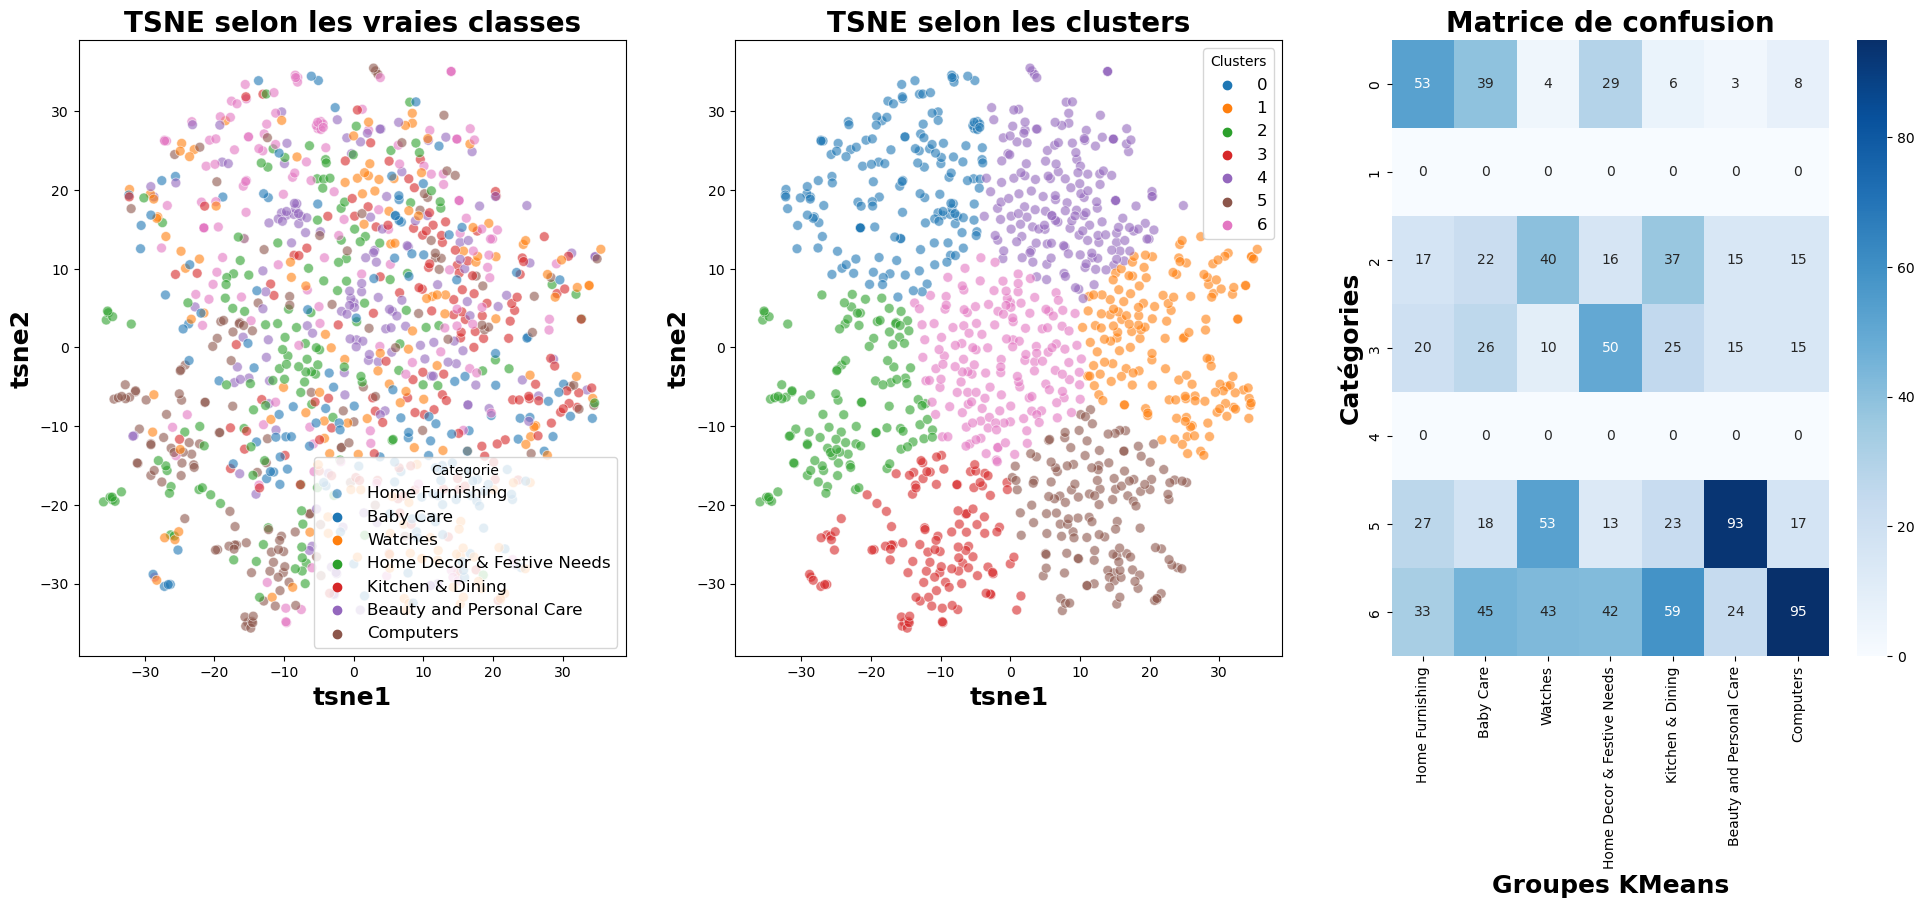

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.061.


In [374]:
# Réduction des dimensions avec PCA
donnees_pca = reduce_dimensionality_pca(caracteristiques_images, 0.99)

# Réduction des dimensions avec t-SNE
donnees_tsne = reduce_dimensionality_tsne(donnees_pca)

# Traçage des clusters KMeans après réduction de dimensions
plot_tsne_and_kmeans_clusters(donnees_tsne)

## CNN

**CNN (Convolutional Neural Network)**, ou réseau de neurones convolutif en français, est une classe spécifique de réseaux de neurones artificiels, principalement utilisée pour l'analyse des images en vision par ordinateur, mais aussi applicable à d'autres types de données comme l'audio et le texte. Les CNN sont particulièrement efficaces pour la reconnaissance des motifs et des structures spatiales dans les données, ce qui en fait un outil puissant pour de nombreuses tâches de traitement des données.

**Principes Fondamentaux des CNN**: Les CNN sont constitués de plusieurs couches, chacune ayant une fonction spécifique dans le traitement des données d'entrée :

1. **Couche de Convolution :**
   - Applique des filtres (ou noyaux) à l'image d'entrée pour créer des cartes de caractéristiques.
   - Chaque filtre détecte des motifs spécifiques comme les bords, les textures, etc.
   - La convolution réduit la taille de l'image tout en conservant les informations essentielles.

2. **Couche de ReLU (Rectified Linear Unit) :**
   - Applique une activation non-linéaire pour introduire de la non-linéarité dans le modèle.
   - Remplace les valeurs négatives par zéro, ce qui aide à la modélisation de relations complexes.

3. **Couche de Pooling :**
   - Réduit la dimensionnalité des cartes de caractéristiques tout en conservant les informations importantes.
   - Le pooling max ou moyenne est couramment utilisé, où seule la valeur maximale ou la moyenne d'une région est conservée.

4. **Couche Complètement Connectée (Fully Connected Layer) :**
   - Relie chaque neurone de la couche précédente à chaque neurone de la couche suivante.
   - Utilisée à la fin du réseau pour combiner les caractéristiques extraites et effectuer des prédictions.

5. **Softmax Layer (optionnelle) :**
   - Appliquée en sortie pour les tâches de classification, elle convertit les valeurs en probabilités.

### Extraction des features

In [375]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
import tqdm

# Chargement du modèle VGG16 pré-entraîné
modele_base = VGG16()

# Création d'un nouveau modèle en utilisant VGG16, mais avec la sortie de l'avant-dernière couche
modele = Model(inputs=modele_base.inputs, outputs=modele_base.layers[-2].output)

# Liste pour stocker les caractéristiques des images
caracteristiques_images = []

# Chemin des images
chemin_images = 'Flipkart/Images/'

# Extraction des caractéristiques pour chaque image
for fichier_image in tqdm.tqdm(df['image']):
    # Chargement de l'image et redimensionnement à la taille requise par VGG16
    image = load_img(chemin_images + fichier_image, target_size=(224, 224))
    
    # Conversion de l'image en tableau numpy
    image = img_to_array(image)
    
    # Ajout d'une dimension supplémentaire pour correspondre à la forme attendue par le modèle
    image = np.expand_dims(image, axis=0)
    
    # Prétraitement de l'image pour correspondre aux attentes de VGG16
    image = preprocess_input(image)
    
    # Extraction des caractéristiques en passant l'image à travers le modèle
    caracteristiques = modele.predict(image, verbose=0)[0]
    
    # Ajout des caractéristiques à la liste
    caracteristiques_images.append(caracteristiques)

# Conversion de la liste des caractéristiques en un tableau numpy
caracteristiques_images = np.asarray(caracteristiques_images)

100%|██████████| 1050/1050 [11:41<00:00,  1.50it/s]


### Réduction dimensionnelle et analyse graphique des clusters

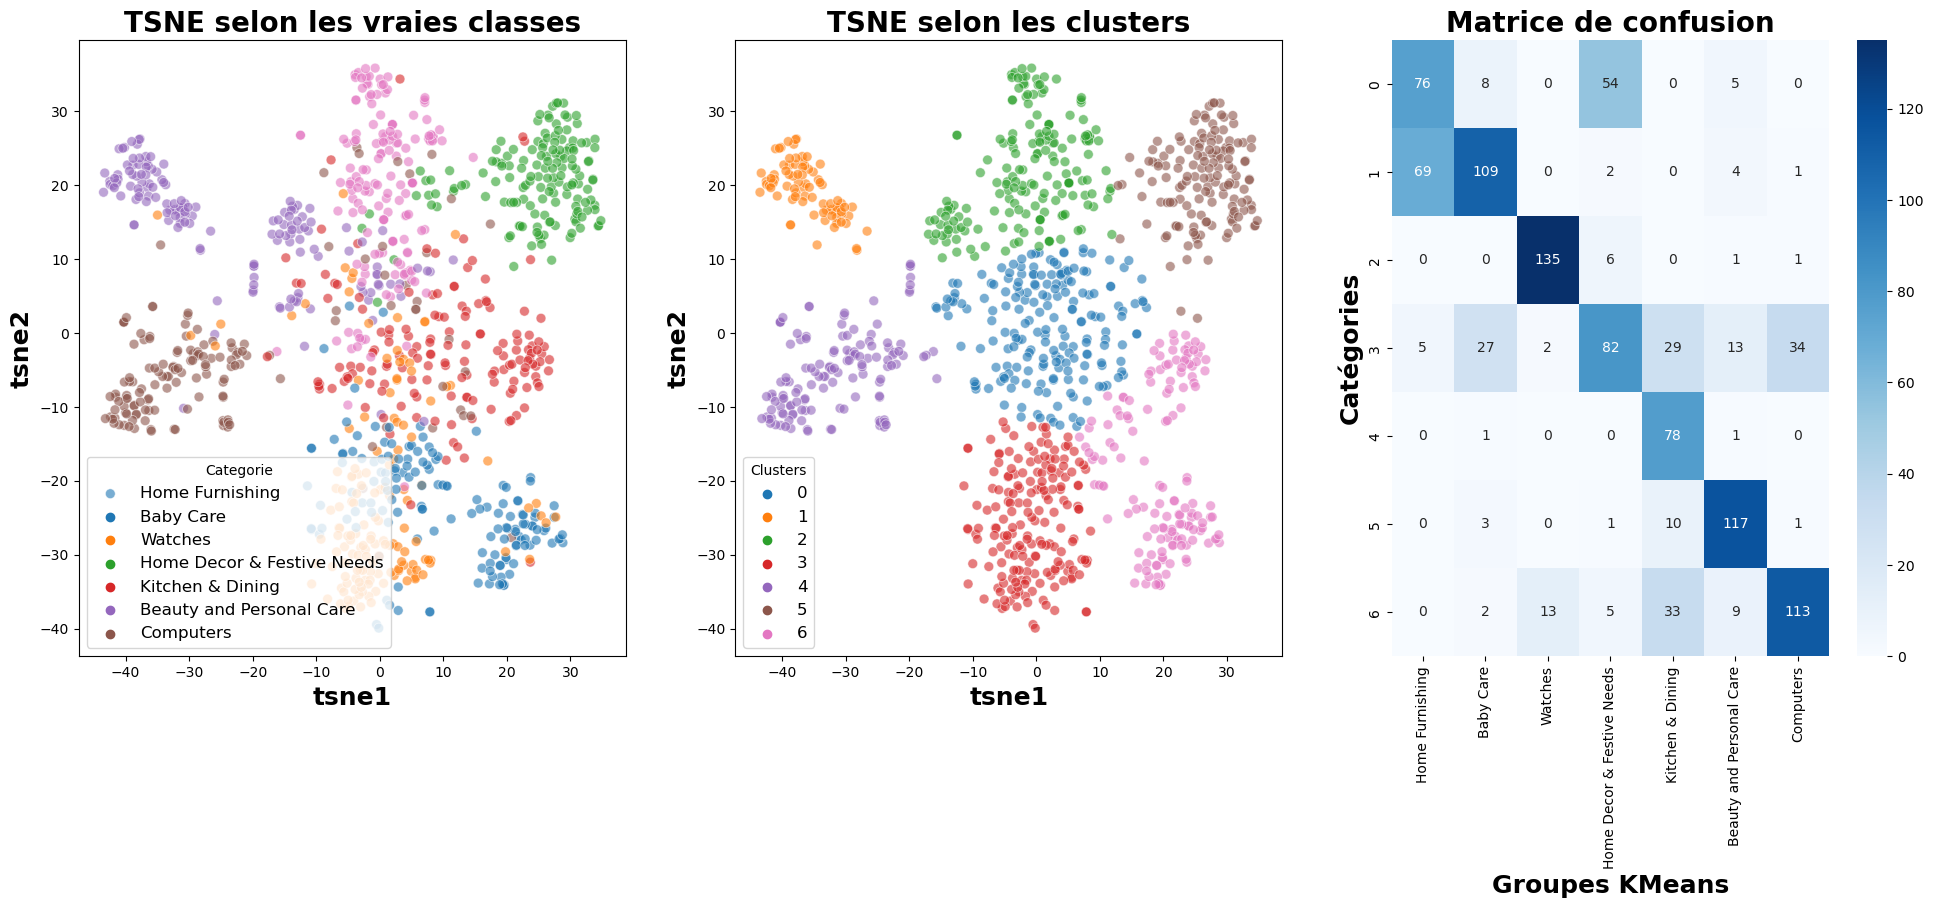

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.457.


In [376]:
# Réduction des dimensions avec PCA
donnees_pca = reduce_dimensionality_pca(caracteristiques_images, 0.99)

# Réduction des dimensions avec t-SNE
donnees_tsne = reduce_dimensionality_tsne(donnees_pca)

# Traçage des clusters KMeans après réduction de dimensions
plot_tsne_and_kmeans_clusters(donnees_tsne)

## Évaluation en combinant les caractéristiques NLP (USE) et d'imagerie (CNN)

In [377]:
# Fusion des caractéristiques NLP et Imagerie
features_cnn = pd.DataFrame(caracteristiques_images)
features_use = embeddings_df

# Fusionner les deux DataFrames sur l'index
nlp_imagerie = pd.merge(features_cnn, features_use, left_index=True, right_index=True)

# Afficher le DataFrame fusionné (optionnel)
nlp_imagerie.head()

0_x       1_x  2_x       3_x       4_x      5_x       6_x  7_x  8_x  \
0  3.398615  0.859574  0.0  1.106561  2.266123  2.92724  2.446447  0.0  0.0   
1  0.000000  0.000000  0.0  1.172009  0.000000  0.00000  0.000000  0.0  0.0   
2  0.000000  0.000000  0.0  4.457806  0.000000  0.00000  0.000000  0.0  0.0   
3  0.000000  0.070989  0.0  2.046279  0.000000  0.00000  0.000000  0.0  0.0   
4  3.417152  0.000000  0.0  0.000000  1.012358  0.00000  0.000000  0.0  0.0   

        9_x      10_x  11_x      12_x  13_x      14_x  15_x      16_x  \
0  0.000000  0.000000   0.0  0.000000   0.0  0.559278   0.0  0.000000   
1  6.499791  0.000000   0.0  0.000000   0.0  0.000000   0.0  0.594591   
2  2.820562  0.000000   0.0  0.000000   0.0  0.000000   0.0  4.381303   
3  0.894022  0.754701   0.0  0.365446   0.0  0.000000   0.0  0.000000   
4  0.000000  0.000000   0.0  1.936735   0.0  0.000000   0.0  0.000000   

       17_x      18_x      19_x      20_x      21_x      22_x      23_x  \
0  0.000000  0.246030  1.012810  4.723425  0.000000  0.000000  0.000000   
1  2.796108  0.000000  0.998303  0.000000  0.000000  0.474828  0.000000   
2  0.457951  0.000000  1.172505  0.000000  0.000000  0.000000  2.119234   
3  0.000000  0.000000  0.000000  0.000000  0.506433  2.758232  0.000000   
4  0.000000  0.502927  1.837906  0.307350  0.000000  0.154490  0.000000   

       24_x     25_x      26_x       27_x  28_x      29_x  30_x      31_x  \
0  1.527079  0.00000  1.475292   0.727806   0.0  0.000000   0.0  1.122838   
1  0.000000  0.00000  0.000000  12.447856   0.0  0.228287   0.0  3.627894   
2  0.000000  0.00000  0.000000   0.175472   0.0  0.089593   0.0  0.000000   
3  0.000000  0.00000  0.210387   3.579497   0.0  0.026015   0.0  0.000000   
4  0.000000  4.07333  0.000000   3.148695   0.0  0.000000   0.0  0.000000   

   32_x      33_x  34_x      35_x      36_x      37_x  38_x  39_x      40_x  \
0   0.0  0.000000   0.0  3.408427  1.094499  1.497914   0.0   0.0  2.367991   
1   0.0  0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0  0.000000   
2   0.0  0.000000   0.0  0.000000  0.000000  1.647265   0.0   0.0  0.000000   
3   0.0  1.036062   0.0  0.000000  0.000000  0.000000   0.0   0.0  0.000000   
4   0.0  0.000000   0.0  2.132994  0.000000  2.182172   0.0   0.0  0.047697   

       41_x  42_x      43_x  44_x      45_x      46_x      47_x  48_x  \
0  2.372084   0.0  2.984932   0.0  6.419507  0.000000  0.000000   0.0   
1  0.000000   0.0  3.320002   0.0  0.000000  1.058609  0.000000   0.0   
2  1.841472   0.0  3.759658   0.0  0.000000  0.877833  0.000000   0.0   
3  2.069358   0.0  3.707275   0.0  0.000000  0.000000  1.222202   0.0   
4  0.000000   0.0  2.694548   0.0  2.830708  3.845764  0.000000   0.0   

       49_x  50_x  51_x  52_x      53_x      54_x  55_x  56_x      57_x  \
0  0.000000   0.0   0.0   0.0  0.000000  0.000000   0.0   0.0  2.067129   
1  4.110570   0.0   0.0   0.0  0.276895  0.234292   0.0   0.0  0.000000   
2  0.000000   0.0   0.0   0.0  0.801309  2.207543   0.0   0.0  0.318710   
3  0.757768   0.0   0.0   0.0  0.000000  0.000000   0.0   0.0  0.000000   
4  0.000000   0.0   0.0   0.0  0.000000  0.000000   0.0   0.0  0.000000   

       58_x      59_x      60_x  61_x      62_x  63_x     64_x      65_x  \
0  0.000000  0.000000  0.000000   0.0  1.577004   0.0  0.00000  3.286893   
1  2.713843  7.922614  0.000000   0.0  0.000000   0.0  0.00000  4.806360   
2  1.571631  3.804742  0.000000   0.0  0.000000   0.0  1.27467  0.242839   
3  2.671740  0.473503  0.598628   0.0  0.000000   0.0  0.00000  0.340577   
4  0.233284  0.000000  0.237469   0.0  0.000000   0.0  0.00000  0.000000   

       66_x  67_x  68_x  69_x  70_x  71_x  72_x  73_x  74_x  75_x      76_x  \
0  0.891427   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.008178   
1  3.012158   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   
2  5.872325   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.278226   
3  0.000000   0.0   0.0   0.0   0.0   0.0 

### Réduction dimensionnelle et analyse graphique des clusters

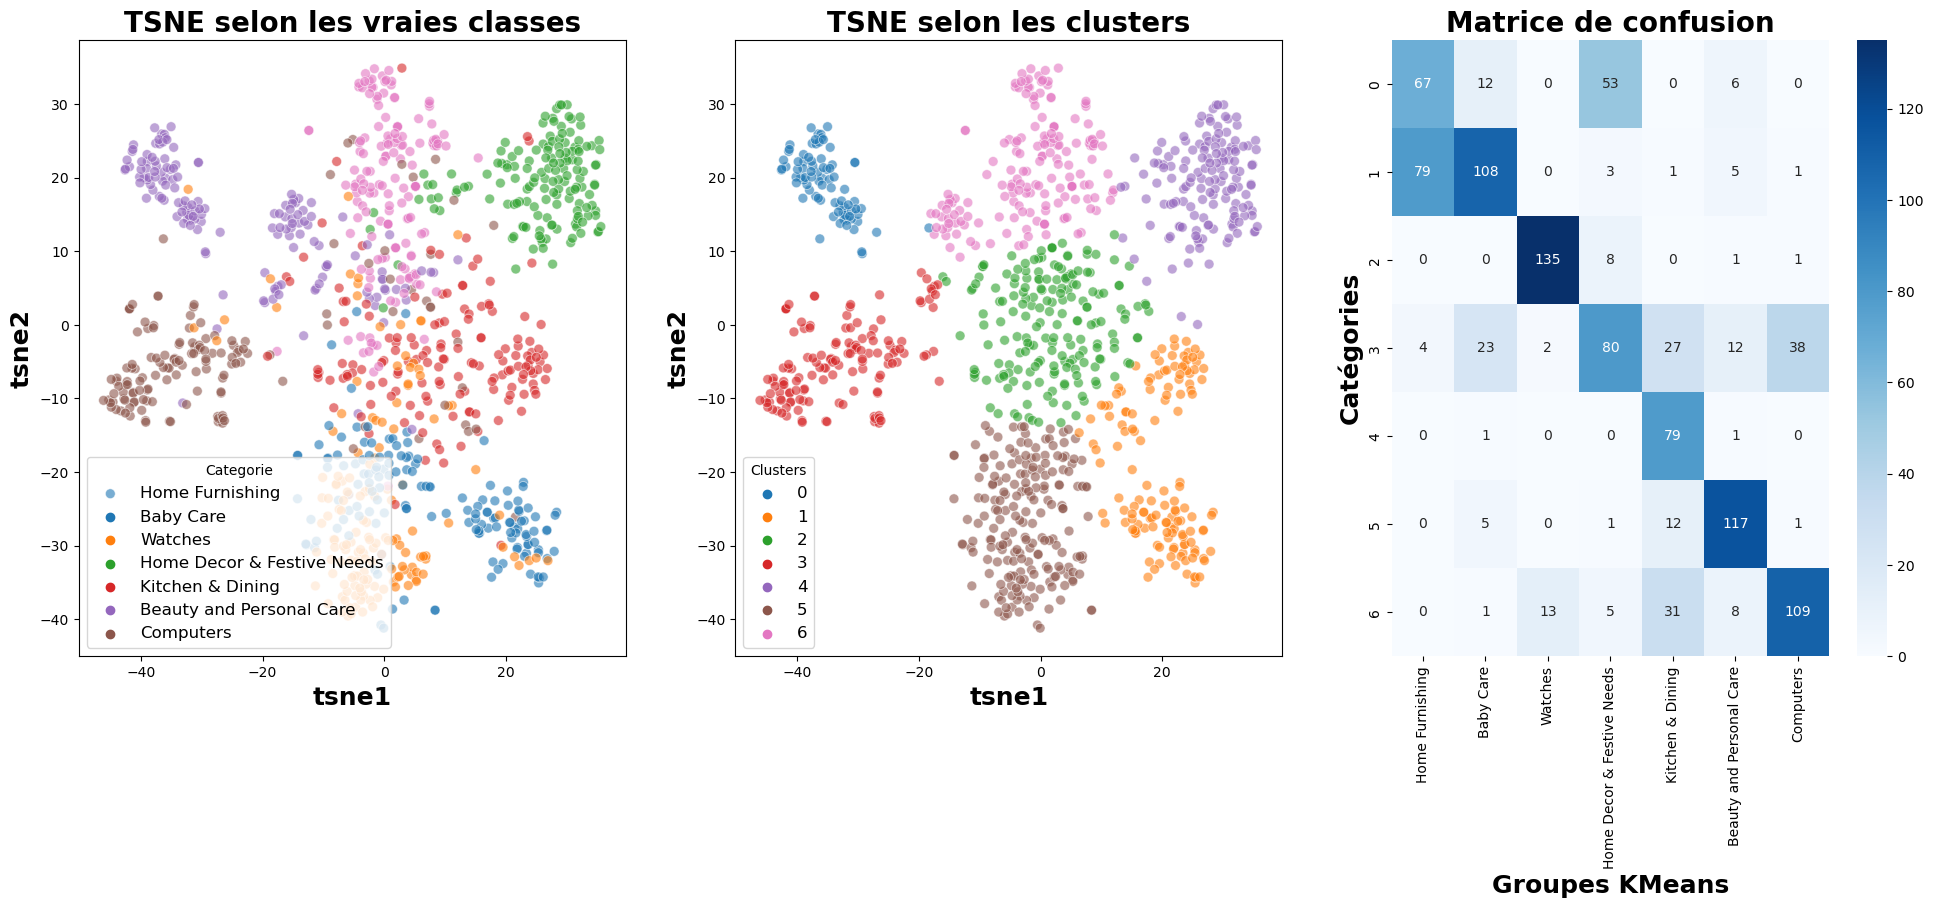

L'indice de Rand ajusté (ARI) pour ce modèle d'extraction de caractéristiques est de 0.449.


In [378]:
# Réduction des dimensions
reduced_pca = reduce_dimensionality_pca(nlp_imagerie.to_numpy(), 0.99)
reduced_tsne = reduce_dimensionality_tsne(reduced_pca)

# Graphiques et score ARI
plot_tsne_and_kmeans_clusters(reduced_tsne)

**En fin de compte, il utilise principalement les caractéristiques du modèle CNN par rapport au modèle NLP.**

## Analyse des résultats à l'aide de CountVectorizer et CNN

### CountVectorizer

In [379]:
# Créer le vecteur bag of words
vectorizer = CountVectorizer().fit(df['DescriptionCompleteTokenizer']) 

# Transformer le texte en une matrice sparse
bow_sparse_matrix = vectorizer.transform(df['DescriptionCompleteTokenizer'])

# Réduction dimensionnelle (PCA n'étant pas adapté aux matrices sparse)
svd_model = TruncatedSVD(n_components=1000, random_state=42)
reduced_data = svd_model.fit_transform(bow_sparse_matrix)


# Apprentissage automatique ou machine learning

X = reduced_data
y = df['Category_Level_1']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle de régression logistique
modele_regression_logistique_CV = LogisticRegression(max_iter=1000)
modele_regression_logistique_CV.fit(X_train, y_train)

# Prédiction sur l'ensemble des données
df['PredictionsNLP'] = modele_regression_logistique_CV.predict(X)

### CNN

In [380]:
# Réduction des dimensions avec PCA
donnees_pca = reduce_dimensionality_pca(caracteristiques_images, 0.99)


# Apprentissage automatique ou machine learning

X_ = donnees_pca
y_ = df['Category_Level_1']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Entraînement du modèle de régression logistique
modele_regression_logistique_CNN = LogisticRegression(max_iter=1000)
modele_regression_logistique_CNN.fit(X_train, y_train)

# Prédiction sur l'ensemble des données
df['PredictionsCNN'] = modele_regression_logistique_CNN.predict(X_)

## Comparaison des deux approches avec les résultats réels

In [381]:
# Comparaison des deux approches avec les résultats réels

# Sélection des colonnes pertinentes pour la comparaison
comparaison_resultats = df[['Category_Level_1', 'PredictionsNLP', 'PredictionsCNN']]

# Calcul du pourcentage de différences entre les prédictions NLP et les résultats réels
erreur_nlp = round((len(comparaison_resultats[comparaison_resultats['Category_Level_1'] != comparaison_resultats['PredictionsNLP']]) / len(comparaison_resultats) * 100), 2)

# Calcul du pourcentage de différences entre les prédictions CNN et les résultats réels
erreur_cnn = round((len(comparaison_resultats[comparaison_resultats['Category_Level_1'] != comparaison_resultats['PredictionsCNN']]) / len(comparaison_resultats) * 100), 2)

# Calcul du pourcentage de différences entre les prédictions NLP et CNN
erreur_nlp_vs_cnn = round((len(comparaison_resultats[comparaison_resultats['PredictionsCNN'] != comparaison_resultats['PredictionsNLP']]) / len(comparaison_resultats) * 100), 2)

# Affichage des résultats
print("Pourcentage de différences entre les prédictions NLP et les résultats réels:", erreur_nlp)
print("Pourcentage de différences entre les prédictions CNN et les résultats réels:", erreur_cnn)
print("Pourcentage de différences entre les prédictions NLP et CNN:", erreur_nlp_vs_cnn)

Pourcentage de différences entre les prédictions NLP et les résultats réels: 0.67
Pourcentage de différences entre les prédictions CNN et les résultats réels: 3.05
Pourcentage de différences entre les prédictions NLP et CNN: 3.43


- **Le Modèle NLP** est très précis et fiable pour cette tâche spécifique, avec une erreur minimale.



- **Le Modèle CNN** est moins précis que le modèle NLP mais reste relativement performant.



- **Comparaison des modèles** : Les deux modèles ont des approches différentes pour les prédictions, avec quelques désaccords notables.

In [382]:
# Comparaison des prédictions des modèles avec les résultats réels

# Nombre d'erreurs des prédictions NLP par rapport aux résultats réels
nombre_erreurs_nlp = len(df[df['Category_Level_1'] != df['PredictionsNLP']])
print("Nombre d'erreurs des prédictions NLP :", nombre_erreurs_nlp)

# Filtrer les lignes où les prédictions NLP sont incorrectes
comparaison_erreurs_nlp = df[df['Category_Level_1'] != df['PredictionsNLP']]

# Nombre d'erreurs des prédictions CNN par rapport aux résultats réels parmi les erreurs NLP
nombre_erreurs_cnn_parmi_erreurs_nlp = len(comparaison_erreurs_nlp[comparaison_erreurs_nlp['Category_Level_1'] != comparaison_erreurs_nlp['PredictionsCNN']])
print("Nombre d'erreurs des prédictions CNN parmi les erreurs NLP :", nombre_erreurs_cnn_parmi_erreurs_nlp)

# Filtrer les lignes où les prédictions CNN sont également incorrectes parmi les erreurs NLP
comparaison_erreurs_cnn_parmi_erreurs_nlp = comparaison_erreurs_nlp[comparaison_erreurs_nlp['Category_Level_1'] != comparaison_erreurs_nlp['PredictionsCNN']]

Nombre d'erreurs des prédictions NLP : 7
Nombre d'erreurs des prédictions CNN parmi les erreurs NLP : 2


**L'utilisation combinée des modèles NLP et CNN permet de réduire de manière significative le nombre de mauvaises réponses, passant de 7 à 2, et améliore ainsi la performance globale du système de prédiction pour le site e-commerce.**


- **Le modèle NLP** a globalement plus de mauvaises réponses (7) par rapport au **modèle CNN**, qui n'a que 2 mauvaises réponses sur les mêmes cas où le **modèle NLP** a échoué.


- Cela suggère que le **modèle CNN** peut parfois corriger les mauvaises réponses faites par le **modèle NLP**, bien qu'il ait aussi des faiblesses propres.

## Évaluation combinée des deux approches

In [383]:
# Obtenir les probabilités prédites par les deux modèles
probabilites_cv = pd.DataFrame(modele_regression_logistique_CV.predict_proba(X))
probabilites_cnn = pd.DataFrame(modele_regression_logistique_CNN.predict_proba(X_))

# Moyenne des probabilités des deux modèles
probabilites_moyenne = (probabilites_cv + probabilites_cnn) / 2

# Déterminer la catégorie prédominante pour chaque produit
categorie_predominante = []
for i in range(len(probabilites_moyenne)):
    categorie_predominante.append(probabilites_moyenne.iloc[i:i+1].T.sort_values(i).index[-1])

# Fusion des résultats de comparaison avec les prédictions
comparaison_avec_categorie = pd.merge(comparaison_resultats, pd.DataFrame(categorie_predominante, columns=['CategoriePredominante']), right_index=True, left_index=True)
print(comparaison_avec_categorie)

# Déterminer les trois meilleures prédictions pour chaque produit avec CountVectorizer
meilleure_categorie1 = []
meilleure_categorie2 = []
meilleure_categorie3 = []
for i in range(len(probabilites_cv)):
    meilleure_categorie1.append(probabilites_cv.iloc[i:i+1].T.sort_values(i).index[-1])
    meilleure_categorie2.append(probabilites_cv.iloc[i:i+1].T.sort_values(i).index[-2])
    meilleure_categorie3.append(probabilites_cv.iloc[i:i+1].T.sort_values(i).index[-3])

# Création d'un DataFrame avec les résultats réels et les trois meilleures prédictions
resultats_comparaison = pd.DataFrame(list(zip(df['Category_Level_1'], meilleure_categorie1, meilleure_categorie2, meilleure_categorie3)),
                                     columns=['CategorieReelle', 'MeilleurePred1', 'MeilleurePred2', 'MeilleurePred3'])

# Afficher le nombre de produits mal classés dans chaque option
produits_mal_classes_pred1 = len(resultats_comparaison[resultats_comparaison['CategorieReelle'] != resultats_comparaison['MeilleurePred1']])
print('Nombre de produits mal classés dans la première prédiction : {}'.format(produits_mal_classes_pred1))

# Filtrer les produits mal classés dans la première meilleure prédiction
resultats_comparaison = resultats_comparaison[resultats_comparaison['CategorieReelle'] != resultats_comparaison['MeilleurePred1']]

produits_mal_classes_pred2 = len(resultats_comparaison[resultats_comparaison['CategorieReelle'] != resultats_comparaison['MeilleurePred2']])
print("Nombre de produits mal classés dans la deuxième prédiction : {}".format(produits_mal_classes_pred2))

# Filtrer les produits mal classés dans la deuxième meilleure prédiction
resultats_comparaison = resultats_comparaison[resultats_comparaison['CategorieReelle'] != resultats_comparaison['MeilleurePred2']]

produits_mal_classes_pred3 = len(resultats_comparaison[resultats_comparaison['CategorieReelle'] != resultats_comparaison['MeilleurePred3']])
print("Nombre de produits mal classés dans la troisième prédiction : {}".format(produits_mal_classes_pred3))

      Category_Level_1  PredictionsNLP  PredictionsCNN  CategoriePredominante
0                    0               0               0                      0
1                    1               1               1                      1
2                    1               1               0                      0
3                    0               0               0                      0
4                    0               0               0                      0
...                ...             ...             ...                    ...
1045                 1               1               1                      1
1046                 1               3               3                      3
1047                 1               1               1                      1
1048                 1               1               3                      1
1049                 1               1               1                      1

[1050 rows x 4 columns]
Nombre de produits mal classés dans la 

Les résultats montrent que le modèle a une performance solide en termes de top-3 accuracy, bien que des améliorations puissent être faites pour réduire le nombre de produits mal classés dans la première prédiction. Utiliser les top-3 prédictions dans un contexte de recommandation de produits peut améliorer significativement l'expérience utilisateur.

# CLASSIFICATION SUPERVISE

3 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [427]:
df.head(3)

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   

                              product_specifications  Category_Level_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...                 0   
1  {"product_specification"=>[{"key"=>"Machine Wa...                 1   
2  {"product_specification"=>[{"key"=>"Material",...                 1   

          Category_Level_2   Category_Level_3  \
0   Curtains & Accessories           Curtains   
1         Baby Bath & Skin   Baby Bath Towels   
2         Baby Bath & Skin   Baby Bath Towels   

                                    Category_Level_4  \
0   Elegance Polyester Multicolor Abstract Eyelet...   
1                          Sathiyas Baby Bath Towels   
2                           Eurospa Baby Bath Towels   

                                    Category_Level_5 Category_Level_6  \
0                                                NaN              NaN   
1   Sathiyas Cotton Bath Towel (3 Bath Towel, Red...              NaN   
2   Eurospa Cotton Terry Face Towel Set (20 PIECE...              NaN   

  Category_Level_7                                DescriptionComplete  \
0              NaN  Elegance Polyester Multicolor Abstract Eyelet ...   
1              NaN  Sathiyas Cotton Bath TowelSpecifications of Sa...   
2              NaN  Eurospa Cotton Terry Face Towel SetKey Feature...   

                        DescriptionCompleteTokenizer Category_Level_1_Texte  
0  eleg polyest multicolor abstract eyelet door c...        Home Furnishing  
1  sathiya cotton bath towelspecif sathiya cotton...              Baby Care  
2  eurospa cotton terri face towel setkey featur ...              Baby Care

### Création du modèle de classification

In [429]:
# Fonction de création du modèle
def create_model_fct():
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# Créer le modèle
#model = create_model_fct()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


## Approche préparation initiale des images

In [444]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import VGG16
import os

# Charger le fichier CSV initial
file_path = 'Data_Final_cleaning_projet_6'
df = pd.read_csv(file_path)

# Diviser les données en ensembles d'entraînement et de test
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

# Réinitialiser l'index des DataFrames
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

# Chemin d'accès aux images
image_directory = r"C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 6\Flipkart\Images"

# Fonction pour créer les chemins d'accès aux images et les étiquettes
def data_fct(data, image_dir):
    data["image_path"] = data["image"].apply(lambda x: os.path.join(image_dir, x))
    data["label"] = data["Category_Level_1"]
    return data

# Créer les DataFrames d'entraînement et de test avec les chemins d'accès aux images et les étiquettes
data_train = data_fct(data_train, image_directory)
data_test = data_fct(data_test, image_directory)

# Fonction de préparation des images
def image_prep_fct(data):
    prepared_images = []
    for image_num in range(len(data['image_path'])):
        img = load_img(data['image_path'][image_num], target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        prepared_images.append(img)
    
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

# Préparer les images d'entraînement et de test
images_np_train = image_prep_fct(data_train)
images_np_test = image_prep_fct(data_test)

# Encoder les étiquettes
le = preprocessing.LabelEncoder()
le.fit(data_train["label"])
data_train["label_encoded"] = le.transform(data_train["label"])
data_test["label_encoded"] = le.transform(data_test["label"])

# Préparer les étiquettes pour l'entraînement et le test
y_train = to_categorical(data_train['label_encoded'])
y_test = to_categorical(data_test['label_encoded'])

# Vérifier les dimensions
print("Shape of training images:", images_np_train.shape)
print("Shape of test images:", images_np_test.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of test labels:", y_test.shape)

# Diviser les données d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(images_np_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

# Vérifier les dimensions après la division
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of training images: (840, 224, 224, 3)
Shape of test images: (210, 224, 224, 3)
Shape of training labels: (840, 7)
Shape of test labels: (210, 7)
Shape of X_train: (630, 224, 224, 3)
Shape of y_train: (630, 7)
Shape of X_val: (210, 224, 224, 3)
Shape of y_val: (210, 7)


In [451]:
# Utiliser les données préparées pour l'entraînement du modèle
X = images_np_train
y = to_categorical(data_train['label_encoded'])

X_test = images_np_test
y_test = to_categorical(data_test['label_encoded'])

# Vérifier les étiquettes
print(y)
print(y_test)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [453]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def create_model_fct():
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layers non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(y_train.shape[1], activation='softmax')(x)  # Ajuster la sortie selon le nombre de classes

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [455]:
# Définition du chemin où les meilleurs poids du modèle seront sauvegardés
model1_save_path1 = "./model1_best_weights.keras"

# Création d'un callback ModelCheckpoint pour sauvegarder le modèle
# Le modèle est sauvegardé uniquement lorsque l'erreur de validation ('val_loss') diminue
# 'verbose=1' permet d'afficher les messages de sauvegarde dans la console
# 'save_best_only=True' assure que seuls les poids du meilleur modèle sont sauvegardés
# 'mode='min'' indique que le moniteur ('val_loss') doit être minimisé
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Création d'un callback EarlyStopping pour arrêter l'entraînement du modèle prématurément
# L'entraînement s'arrête si l'erreur de validation ('val_loss') ne s'améliore pas après un certain nombre d'époques
# 'mode='min'' indique que le moniteur ('val_loss') doit être minimisé
# 'verbose=1' permet d'afficher les messages d'arrêt dans la console
# 'patience=5' signifie que l'entraînement s'arrête après 5 époques sans amélioration de 'val_loss'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Liste des callbacks à utiliser lors de l'entraînement du modèle
callbacks_list = [checkpoint, es]

In [456]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): # Utiliser le GPU pour l'entraînement si disponible
    
    # Appel de la méthode fit pour entraîner le modèle
    # X_train, y_train : données et étiquettes d'entraînement
    # epochs : nombre d'époques d'entraînement (50 ici)
    # batch_size : taille du lot (64 ici)
    # callbacks : liste de callbacks à utiliser pendant l'entraînement (par exemple, EarlyStopping et ModelCheckpoint)
    # validation_data : données et étiquettes de validation (X_val, y_val)
    # verbose : niveau de verbosité (1 affiche les informations de progression)
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.3081 - loss: 8.1797 
Epoch 1: val_loss improved from inf to 1.36980, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 325s 33s/step - accuracy: 0.3195 - loss: 7.9324 - val_accuracy: 0.7190 - val_loss: 1.3698
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.6323 - loss: 2.0475 
Epoch 2: val_loss improved from 1.36980 to 1.07350, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 313s 32s/step - accuracy: 0.6329 - loss: 2.0360 - val_accuracy: 0.8095 - val_loss: 1.0735
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7369 - loss: 1.1055 
Epoch 3: val_loss improved from 1.07350 to 0.91870, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 321s 32s/step - accuracy: 0.7369 - loss: 1.1100 - val_accuracy: 0.7810 - val_loss: 0.9187
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8080 - loss: 0.7803 
Epoch 4: val_loss improve

In [458]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

print()

# Score de l'epoch optimal
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.9847 - loss: 0.0578
Training Accuracy: 0.9905

7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.8198 - loss: 0.8262
Validation Accuracy:  0.8190

Validation Accuracy :  0.8190
Test Accuracy       :  0.8429


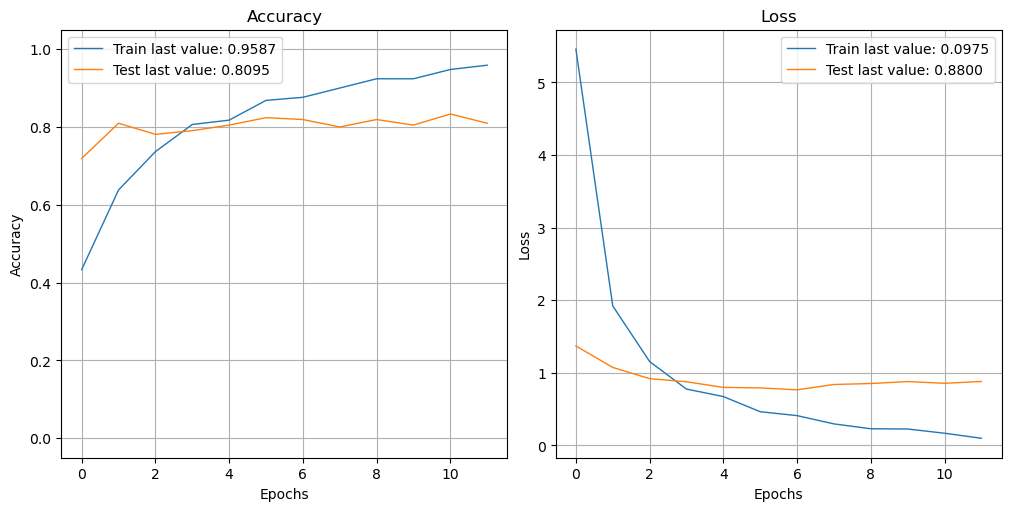

In [460]:
from plot_keras_history import show_history, plot_history

# Affiche l'historique d'entraînement du modèle
# Trace l'historique et sauvegarde le graphique sous forme d'image
# Ferme toutes les figures de Matplotlib
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

#### Exactitude (Accuracy)
- **Augmentation de l'exactitude sur l'ensemble d'entraînement** : On observe que l'exactitude sur les données d'entraînement (ligne bleue) augmente de manière significative, atteignant environ 0.96 après 10 époques. Cela indique que le modèle s'ajuste bien aux données d'entraînement.
- **Stabilité de l'exactitude sur l'ensemble de validation** : L'exactitude sur les données de validation (ligne orange) atteint environ 0.81, mais elle semble stagner ou légèrement fluctuer après quelques époques. Cela peut indiquer que le modèle commence à s'ajuster aux particularités des données d'entraînement, sans nécessairement généraliser aussi bien sur les données de validation.

#### Perte (Loss)
- **Diminution de la perte sur l'ensemble d'entraînement** : La perte sur les données d'entraînement (ligne bleue) diminue régulièrement, ce qui est un signe positif de convergence du modèle.
- **Stabilité ou légère diminution de la perte sur l'ensemble de validation** : La perte sur les données de validation (ligne orange) diminue initialement puis se stabilise autour de 0.88. Cela peut suggérer que le modèle ne continue pas à s'améliorer sur les données de validation après les premières époques.

In [461]:
# Prédiction et affichage des étiquettes prédictives et réelles
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

print("True labels (y_val_num):")
print(y_val_num)
print()
print("Predicted labels (y_val_pred):")
print(y_val_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step
True labels (y_val_num):
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 5 3 1 2 6 5 2 0 1 6 4 6 5 3 4 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 3 0 4 5
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

Predicted labels (y_val_pred):
[6 2 5 2 6 1 1 0 2 3 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 6 4 5 3 4 2 5 0 2
 5 5 3 1 2 6 5 2 0 1 6 4 6 5 3 4 3 1 3 5 4 6 0 4 1 6 1 2 5 0 3 1 0 5 3 6 1
 4 6 2 4 5 1 4 0 5 4 1 1 2 2 3 1 3 5 4 3 5 4 3 0 2 1 3 4 5 1 4 4 6 1 1 4 3
 1 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 4 5 1 2 6 0 6 0 3 3 4 3 3 5 1 0 5 5 0
 5 4 0 6 0 5 4 0 2 4 0 2 4 1 6 2 4 0 1 2 4 1 0 2 4 6 4 4 4 0 0 0 6 3 0 4 5
 5 0 2 4 1 6 0 4 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]


In [462]:
from sklearn import metrics

# Calcul et affichage de la matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[22  4  0  1  0  1  1]
 [ 3 26  0  0  1  0  1]
 [ 0  0 27  0  1  0  1]
 [ 2  0  0 25  3  0  0]
 [ 0  0  0  1 27  1  2]
 [ 1  3  0  1  0 25  2]
 [ 1  1  0  1  2  3 20]]


In [463]:
# Fonction de transformation des prédictions (à définir)
def conf_mat_transform(y_true, y_pred):
    # Exemple de transformation, à adapter selon vos besoins
    return y_pred  # Aucune transformation pour l'exemple

# Transformation des prédictions et nouvelle matrice de confusion
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat_transformed = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print("Transformed Confusion Matrix:")
print(conf_mat_transformed)

Transformed Confusion Matrix:
[[22  4  0  1  0  1  1]
 [ 3 26  0  0  1  0  1]
 [ 0  0 27  0  1  0  1]
 [ 2  0  0 25  3  0  0]
 [ 0  0  0  1 27  1  2]
 [ 1  3  0  1  0 25  2]
 [ 1  1  0  1  2  3 20]]


In [464]:
# Génération du rapport de classification
print("Classification Report:")
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        29
           1       0.76      0.84      0.80        31
           2       1.00      0.93      0.96        29
           3       0.86      0.83      0.85        30
           4       0.79      0.87      0.83        31
           5       0.83      0.78      0.81        32
           6       0.74      0.71      0.73        28

    accuracy                           0.82       210
   macro avg       0.82      0.82      0.82       210
weighted avg       0.82      0.82      0.82       210




#### Moyennes Globales

- **Accuracy (Exactitude)** : 0.82
  - L'exactitude globale du modèle sur l'ensemble de test est de 82%.
  
- **Macro Average** :
  - Moyenne non pondérée de la précision, du rappel et du F1-score.
  - Précision : 0.82
  - Rappel : 0.82
  - F1-Score : 0.82
  
- **Weighted Average** :
  - Moyenne pondérée de la précision, du rappel et du F1-score, en tenant compte du support de chaque classe.
  - Précision : 0.82
  - Rappel : 0.82
  - F1-Score : 0.82

### Observation

Le modèle a une performance globale solide avec une exactitude de 82%. Cependant, il y a des variations dans les performances pour différentes classes :
- La classe 2 a une performance exceptionnelle.
- Les classes 0, 1, 4, 5 et 6 pourraient bénéficier d'améliorations supplémentaires, notamment la classe 6 qui a la performance la plus faible.

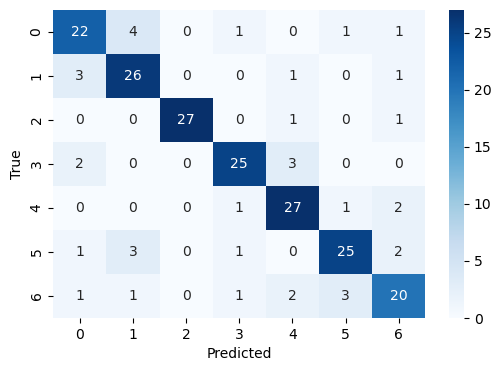

In [466]:
# Définir les labels des classes (à adapter selon vos classes réelles)
list_labels = le.classes_

# Affichage de la matrice de confusion avec heatmap
df_cm = pd.DataFrame(conf_mat_transformed, index = [label for label in list_labels],
                     columns = [i for i in range(len(list_labels))])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Observations Générales

- **Bonne Performance** : 
  - Les valeurs sur la diagonale principale sont élevées par rapport aux autres valeurs de leur ligne respective, ce qui signifie que la plupart des instances sont correctement classifiées.
  - Les classes 2 et 4 montrent une très bonne performance avec des valeurs de 27 et 25 respectivement sur la diagonale, indiquant des prédictions très précises pour ces classes.

- **Erreurs de Classification** :
  - Il y a quelques erreurs de classification, comme 4 instances de la classe 0 étant classifiées comme 1.
  - Les classes avec quelques erreurs notables incluent la classe 3, avec 3 instances incorrectement classifiées comme 4, et la classe 6 avec plusieurs instances mal classifiées.

#### Amélioration Potentielle

- **Analyser les Erreurs** : Comprendre pourquoi certaines classes sont confondues peut aider à améliorer le modèle. Par exemple, les classes 0 et 1 sont souvent confondues.
- **Augmentation de Données** : Utiliser des techniques d'augmentation de données pour les classes mal classifiées pourrait aider à améliorer la précision.
- **Régularisation et Tuning** : Ajuster les hyperparamètres et utiliser des techniques de régularisation pour améliorer la généralisation du modèle.

### Conclusion

La matrice de confusion montre que le modèle fonctionne bien dans l'ensemble avec une bonne précision pour la majorité des classes. Il y a quelques erreurs de classification spécifiques qui peuvent être analysées et corrigées pour améliorer encore la performance du modèle.

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [492]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [493]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Charger le fichier CSV initial
file_path = 'Data_Final_cleaning_projet_6'
df = pd.read_csv(file_path)

# Diviser les données en ensembles d'entraînement et de test
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

# Réinitialiser l'index des DataFrames
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

# Chemin d'accès aux images
image_directory = r"C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 6\Flipkart\Images"

# Fonction pour créer les chemins d'accès aux images et les étiquettes
def data_fct(data, image_dir):
    data["image_path"] = data["image"].apply(lambda x: os.path.join(image_dir, x))
    data["label"] = data["Category_Level_1"].astype(str)  # Convertir en chaînes de caractères
    return data

# Créer les DataFrames d'entraînement et de test avec les chemins d'accès aux images et les étiquettes
data_train = data_fct(data_train, image_directory)
data_test = data_fct(data_test, image_directory)

In [494]:
# Importation de la classe ImageDataGenerator pour la génération d'images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définition de la taille du batch
batch_size = 32

# Fonction pour créer un flux de données à partir d'un DataFrame
def data_flow_fct(data, datagen, data_type=None):
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label',
                                target_size=(224, 224),  # Mettre à jour pour correspondre à l'entrée du modèle
                                class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type)
    return data_flow

# Définir les générateurs de données avec augmentation pour l'entraînement et la validation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

# Création des flux de données pour l'entraînement et la validation
train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

# Définir le générateur de données pour le test (sans augmentation)
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Création du flux de données pour le test
test_flow = data_flow_fct(data_test, datagen_test)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [495]:
# Calculer le nombre de classes dans data_train
num_classes = data_train['label'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [496]:
# Fonction de création du modèle
def create_model_fct(num_classes):
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layers non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Ajuster la sortie selon le nombre de classes

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct(num_classes)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [497]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Définition du chemin où les meilleurs poids du modèle seront sauvegardés
model2_save_path = "./model2_best_weights.keras"

# Création d'un callback ModelCheckpoint pour sauvegarder le modèle
# Le modèle est sauvegardé uniquement lorsque l'erreur de validation ('val_loss') diminue
# 'verbose=1' permet d'afficher les messages de sauvegarde dans la console
# 'save_best_only=True' assure que seuls les poids du meilleur modèle sont sauvegardés
# 'mode='min'' indique que le moniteur ('val_loss') doit être minimisé
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Création d'un callback EarlyStopping pour arrêter l'entraînement du modèle prématurément
# L'entraînement s'arrête si l'erreur de validation ('val_loss') ne s'améliore pas après un certain nombre d'époques
# 'mode='min'' indique que le moniteur ('val_loss') doit être minimisé
# 'verbose=1' permet d'afficher les messages d'arrêt dans la console
# 'patience=5' signifie que l'entraînement s'arrête après 5 époques sans amélioration de 'val_loss'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Liste des callbacks à utiliser lors de l'entraînement du modèle
callbacks_list = [checkpoint, es]

In [498]:
# Vérifier le nombre de GPU disponibles
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Entraîner le modèle en utilisant le premier GPU disponible
with tf.device('/gpu:0'):
    # Appel de la méthode fit pour entraîner le modèle
    # train_flow : flux de données d'entraînement
    # validation_data : flux de données de validation
    # epochs : nombre d'époques d'entraînement (50 ici)
    # callbacks : liste de callbacks à utiliser pendant l'entraînement (par exemple, EarlyStopping et ModelCheckpoint)
    # verbose : niveau de verbosité (1 affiche les informations de progression)
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    epochs=50, callbacks=callbacks_list, verbose=1)

Num GPUs Available:  0
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3529 - loss: 6.6094
Epoch 1: val_loss improved from inf to 1.16674, saving model to ./model2_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 215s 11s/step - accuracy: 0.3569 - loss: 6.5198 - val_accuracy: 0.6857 - val_loss: 1.1667
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6044 - loss: 2.2081
Epoch 2: val_loss improved from 1.16674 to 0.90461, saving model to ./model2_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 211s 10s/step - accuracy: 0.6054 - loss: 2.1981 - val_accuracy: 0.7762 - val_loss: 0.9046
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6939 - loss: 1.4094
Epoch 3: val_loss improved from 0.90461 to 0.80461, saving model to ./model2_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 212s 10s/step - accuracy: 0.6945 - loss: 1.4047 - val_accuracy: 0.8048 - val_loss: 0.8046
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7368 - loss: 0.9437
Epoch 4: v

In [499]:
# Score du dernier epoch
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

print()

# Score de l'epoch optimal
model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - accuracy: 0.9578 - loss: 0.0974
Training Accuracy   : 0.9619

7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.7994 - loss: 0.9370
Validation Accuracy :  0.8048

Validation Accuracy :  0.7952
Test Accuracy       :  0.7667


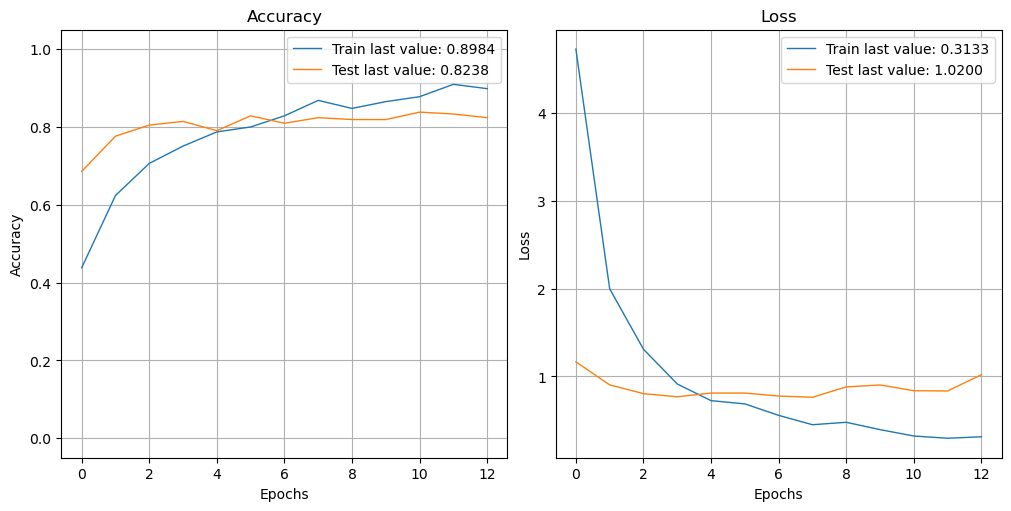

In [500]:
from plot_keras_history import show_history, plot_history

# Affiche l'historique d'entraînement du modèle
show_history(history2)

# Trace l'historique et sauvegarde le graphique sous forme d'image
plot_history(history2, path="standard.png")

# Ferme toutes les figures de Matplotlib
plt.close()

### Interprétation des Graphiques d'Entraînement et de Validation

#### Graphique de l'Exactitude (Accuracy)
- **Ligne bleue (Train)** : Représente l'évolution de l'exactitude sur les données d'entraînement au fil des époques.
- **Ligne orange (Test)** : Représente l'évolution de l'exactitude sur les données de validation au fil des époques.

#### Graphique de la Perte (Loss)
- **Ligne bleue (Train)** : Représente l'évolution de la perte sur les données d'entraînement au fil des époques.
- **Ligne orange (Test)** : Représente l'évolution de la perte sur les données de validation au fil des époques.

### Observations Générales

#### Exactitude (Accuracy)
- **Augmentation de l'exactitude sur l'ensemble d'entraînement** : L'exactitude sur les données d'entraînement (ligne bleue) augmente régulièrement pour atteindre environ 0.8984 après 12 époques. Cela indique que le modèle s'ajuste bien aux données d'entraînement.
- **Augmentation de l'exactitude sur l'ensemble de validation** : L'exactitude sur les données de validation (ligne orange) augmente également et atteint environ 0.8238 après 12 époques. Cela montre que le modèle généralise relativement bien aux nouvelles données.

#### Perte (Loss)
- **Diminution de la perte sur l'ensemble d'entraînement** : La perte sur les données d'entraînement (ligne bleue) diminue régulièrement pour atteindre environ 0.3133 après 12 époques, ce qui est un bon signe de convergence.
- **Stabilité de la perte sur l'ensemble de validation** : La perte sur les données de validation (ligne orange) diminue initialement, puis se stabilise autour de 1.0200 après 12 époques. Cette stabilité peut suggérer que le modèle commence à atteindre une limite de généralisation.

### Conclusion et Actions Possibles

1. **Bon Ajustement Global** :
   - Le modèle montre une bonne performance à la fois sur les données d'entraînement et de validation, avec une exactitude relativement élevée.
   - La perte diminue bien sur les données d'entraînement, indiquant une convergence correcte.

2. **Surapprentissage Modéré (Overfitting)** :
   - L'écart entre l'exactitude d'entraînement et l'exactitude de validation suggère un léger surapprentissage. Cela peut être confirmé par la stabilité de la perte de validation qui cesse de diminuer après certaines époques.
   - Pour atténuer cela, vous pourriez :
     - **Régularisation** : Ajouter ou augmenter les techniques de régularisation comme Dropout ou L2 regularization.

Le modèle fonctionne bien dans l'ensemble, avec une bonne performance de classification. Cependant, il y a un léger surapprentissage qui pourrait être réduit avec des techniques supplémentaires de régularisation et d'augmentation des données.

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation


Ce didacticiel illustre l'augmentation des données : une technique permettant d'augmenter la diversité de votre ensemble d'entraînement en appliquant des transformations aléatoires (mais réalistes), telles que la rotation d'image.

Vous apprendrez à appliquer l'augmentation des données de deux manières :

- Utilisez les couches de prétraitement Keras, telles que `tf.keras.layers.Resizing`, `tf.keras.layers.Rescaling`, `tf.keras.layers.RandomFlip` et `tf.keras.layers.RandomRotation`.
- Utilisez les méthodes `tf.image`, telles que `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop` et `tf.image.stateless_random*`.

In [539]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from plot_keras_history import show_history, plot_history
import os

# Vérifier les GPU disponibles
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [540]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from sklearn.model_selection import train_test_split

# Définir les chemins d'accès aux images
image_directory = r"C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 6\Flipkart\Images"

# Charger le fichier CSV initial contenant les données d'images et leurs étiquettes
file_path = 'Data_Final_cleaning_projet_6'
df = pd.read_csv(file_path)

# Diviser les données en ensembles d'entraînement (80%) et de test (20%)
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

# Réinitialiser l'index des DataFrames pour qu'ils commencent à 0
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

# Fonction pour ajouter les chemins d'accès complets aux images et les étiquettes
def data_fct(data, image_dir):
    # Ajouter le chemin complet des images
    data["image_path"] = data["image"].apply(lambda x: os.path.join(image_dir, x))
    # Copier les étiquettes de catégorie
    data["label_name"] = data["Category_Level_1_Texte"]
    return data

# Créer les DataFrames d'entraînement et de test avec les chemins d'accès aux images et les étiquettes
data_train = data_fct(data_train, image_directory)
data_test = data_fct(data_test, image_directory)

# Encoder les étiquettes en one-hot
encoder = LabelBinarizer()
data_train['label_encoded'] = list(encoder.fit_transform(data_train['label_name']))
data_test['label_encoded'] = list(encoder.transform(data_test['label_name']))

# Définir la taille du batch pour le traitement par lot
# Définir la taille des images après redimensionnement
batch_size = 32
IMG_SIZE = 224

# Fonction pour lire, décoder et redimensionner les images
def process_path(file_path, label):
    # Lire le fichier d'image
    img = tf.io.read_file(file_path)
    # Décoder l'image JPEG
    img = tf.image.decode_jpeg(img, channels=3)
    # Redimensionner l'image à la taille définie
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    # Convertir l'image en type de données float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label

# Fonction pour préparer le dataset TensorFlow
def prepare_dataset(data, batch_size=batch_size, shuffle=True, augment=False):
    # Créer un dataset à partir des chemins des images et des étiquettes encodées
    path_ds = tf.data.Dataset.from_tensor_slices((data['image_path'], list(data['label_encoded'])))
    # Appliquer la fonction de traitement des images
    image_label_ds = path_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Mélanger le dataset si nécessaire
    if shuffle:
        image_label_ds = image_label_ds.shuffle(buffer_size=len(data))
    
    # Appliquer des augmentations de données si nécessaire
    if augment:
        image_label_ds = image_label_ds.map(lambda img, lbl: (tf.image.random_flip_left_right(img), lbl),
                                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Diviser le dataset en batches
    image_label_ds = image_label_ds.batch(batch_size)
    # Précharger les données pour améliorer les performances
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return image_label_ds

# Préparer les datasets d'entraînement et de validation avec augmentation pour l'entraînement
dataset_train = prepare_dataset(data_train, batch_size=batch_size, shuffle=True, augment=True)
dataset_val = prepare_dataset(data_test, batch_size=batch_size, shuffle=False, augment=False)

In [541]:
# Fonction pour créer un modèle avec data augmentation et VGG16 pré-entraîné
def create_model_fct2():
    # Définir les transformations de data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)), # Flip horizontal des images
        RandomRotation(0.1), # Rotation aléatoire des images
        RandomZoom(0.1) # Zoom aléatoire sur les images
    ])
    
    # Charger le modèle VGG16 pré-entraîné sans la couche de classification supérieure
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Geler les poids des couches du modèle VGG16 pour éviter de les entraîner à nouveau
    for layer in model_base.layers:
        layer.trainable = False

    # Vérifier et imprimer les formes de sortie des couches de data augmentation et VGG16
    print("Data augmentation output shape:", data_augmentation.output_shape)
    print("VGG16 output shape:", model_base.output_shape)

    # Définir le nouveau modèle en ajoutant des couches de data augmentation, de pré-traitement et de classification
    model = Sequential([
                data_augmentation, # Ajouter les transformations de data augmentation
                Rescaling(1./127.5, offset=-1), # Normaliser les images entre -1 et 1
                model_base, # Ajouter le modèle VGG16 pré-entraîné
                GlobalAveragePooling2D(), # Ajouter une couche de pooling global
                Dense(256, activation='relu'), # Ajouter une couche dense avec 256 neurones et activation ReLU
                Dropout(0.5), # Ajouter une couche de dropout pour éviter le surapprentissage
                Dense(len(encoder.classes_), activation='softmax') # Ajouter la couche de sortie avec activation softmax
                ])

    # Compiler le modèle en spécifiant la fonction de perte, l'optimiseur et les métriques d'évaluation
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Construire explicitement le modèle avec la bonne forme d'entrée
    model.build((None, IMG_SIZE, IMG_SIZE, 3))
    
    # Afficher un résumé du modèle
    print(model.summary())
    
    return model

# Création du modèle en utilisant un GPU si disponible
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

Data augmentation output shape: (None, 224, 224, 3)
VGG16 output shape: (None, 7, 7, 512)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [542]:
# Définition du chemin où les meilleurs poids du modèle seront sauvegardés
model4_save_path = "./model4_best_weights.keras"

# Création d'un callback ModelCheckpoint pour sauvegarder le modèle
# Le modèle est sauvegardé uniquement lorsque l'erreur de validation ('val_loss') diminue
# 'verbose=1' permet d'afficher les messages de sauvegarde dans la console
# 'save_best_only=True' assure que seuls les poids du meilleur modèle sont sauvegardés
# 'mode='min'' indique que le moniteur ('val_loss') doit être minimisé
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Création d'un callback EarlyStopping pour arrêter l'entraînement du modèle prématurément
# L'entraînement s'arrête si l'erreur de validation ('val_loss') ne s'améliore pas après un certain nombre d'époques
# 'mode='min'' indique que le moniteur ('val_loss') doit être minimisé
# 'verbose=1' permet d'afficher les messages d'arrêt dans la console
# 'patience=5' signifie que l'entraînement s'arrête après 5 époques sans amélioration de 'val_loss'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Liste des callbacks à utiliser lors de l'entraînement du modèle
callbacks_list = [checkpoint, es]

In [543]:
# Entraîner le modèle
# Appel de la méthode fit pour entraîner le modèle
# dataset_train : dataset utilisé pour l'entraînement
# validation_data : dataset utilisé pour la validation
# epochs : nombre d'époques d'entraînement
# callbacks : liste de callbacks à utiliser pendant l'entraînement (par exemple, EarlyStopping et ModelCheckpoint)
# verbose : niveau de verbosité (1 affiche les informations de progression)
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2266 - loss: 1.9287
Epoch 1: val_loss improved from inf to 1.38692, saving model to ./model4_best_weights.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 260s 9s/step - accuracy: 0.2296 - loss: 1.9240 - val_accuracy: 0.6048 - val_loss: 1.3869
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5325 - loss: 1.4038
Epoch 2: val_loss improved from 1.38692 to 1.05610, saving model to ./model4_best_weights.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 251s 9s/step - accuracy: 0.5337 - loss: 1.4017 - val_accuracy: 0.7095 - val_loss: 1.0561
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6807 - loss: 1.0649
Epoch 3: val_loss improved from 1.05610 to 0.86271, saving model to ./model4_best_weights.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 263s 10s/step - accuracy: 0.6799 - loss: 1.0656 - val_accuracy: 0.7619 - val_loss: 0.8627
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6622 - loss: 1.0471
Epoch 4: val_loss improved from 0.8

In [548]:
# Préparer l'ensemble de test
dataset_test = prepare_dataset(data_test, batch_size=batch_size, shuffle=False, augment=False)

# Évaluation du modèle
# Score du dernier epoch
loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

print()

# Score de l'epoch optimal
model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

27/27 ━━━━━━━━━━━━━━━━━━━━ 319s 11s/step - accuracy: 0.8263 - loss: 0.5050
Training Accuracy   : 0.8345

7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.7595 - loss: 0.6232
Validation Accuracy :  0.7714

Validation Accuracy :  0.7714
Test Accuracy       :  0.7714


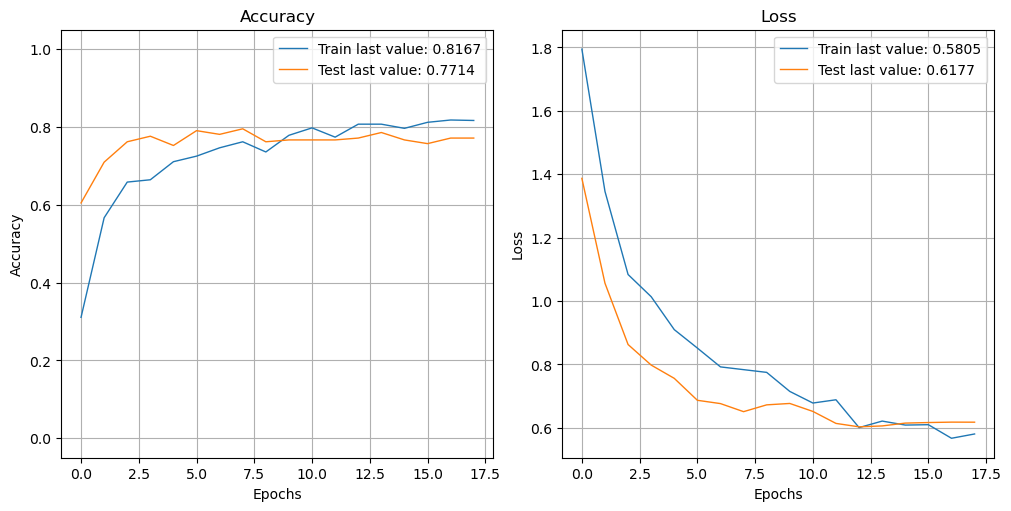

In [545]:
# Affiche l'historique d'entraînement du modèle
show_history(history4)

# Trace l'historique et sauvegarde le graphique sous forme d'image
plot_history(history4, path="standard.png")

# Ferme toutes les figures de Matplotlib
plt.close()

### Interprétation des Graphiques d'Entraînement et de Validation

#### Graphique de l'Exactitude (Accuracy)
- **Ligne bleue (Train)** : Représente l'évolution de l'exactitude sur les données d'entraînement au fil des époques.
- **Ligne orange (Test)** : Représente l'évolution de l'exactitude sur les données de validation au fil des époques.

#### Graphique de la Perte (Loss)
- **Ligne bleue (Train)** : Représente l'évolution de la perte sur les données d'entraînement au fil des époques.
- **Ligne orange (Test)** : Représente l'évolution de la perte sur les données de validation au fil des époques.

### Observations Générales

#### Exactitude (Accuracy)
- **Augmentation de l'exactitude sur l'ensemble d'entraînement** : L'exactitude sur les données d'entraînement (ligne bleue) augmente régulièrement pour atteindre environ 0.8167 après 17,5 époques. Cela indique que le modèle s'ajuste bien aux données d'entraînement.
- **Augmentation de l'exactitude sur l'ensemble de validation** : L'exactitude sur les données de validation (ligne orange) augmente également et atteint environ 0.7714 après 17,5 époques. Cela montre que le modèle généralise relativement bien aux nouvelles données.

#### Perte (Loss)
- **Diminution de la perte sur l'ensemble d'entraînement** : La perte sur les données d'entraînement (ligne bleue) diminue régulièrement pour atteindre environ 0.5805 après 17,5 époques, ce qui est un bon signe de convergence.
- **Diminution de la perte sur l'ensemble de validation** : La perte sur les données de validation (ligne orange) diminue également, mais se stabilise autour de 0.6177 après 17,5 époques. Cette stabilité peut suggérer que le modèle commence à atteindre une limite de généralisation.

### Conclusion et Actions Possibles

1. **Bon Ajustement Global** :
   - Le modèle montre une bonne performance à la fois sur les données d'entraînement et de validation, avec une exactitude relativement élevée.
   - La perte diminue bien sur les données d'entraînement, indiquant une convergence correcte.

2. **Surapprentissage Modéré (Overfitting)** :
   - L'écart entre l'exactitude d'entraînement et l'exactitude de validation suggère un léger surapprentissage. Cela peut être confirmé par la stabilisation de la perte de validation après certaines époques.
   - Pour atténuer cela, vous pourriez :
     - **Régularisation** : Ajouter ou augmenter les techniques de régularisation comme Dropout ou L2 regularization.


Le modèle fonctionne bien dans l'ensemble, avec une bonne performance de classification. Cependant, il y a un léger surapprentissage qui pourrait être réduit avec des techniques supplémentaires de régularisation et d'augmentation des données.